*Social Graphs and Interactions, Fall 2021, DTU*

# Final Project Notebook: Rick and Morty analysis

**"I don't do magic Morty, I do science. One takes brain, the other takes dark eyeliner" - Pickle Rick, S03E03**

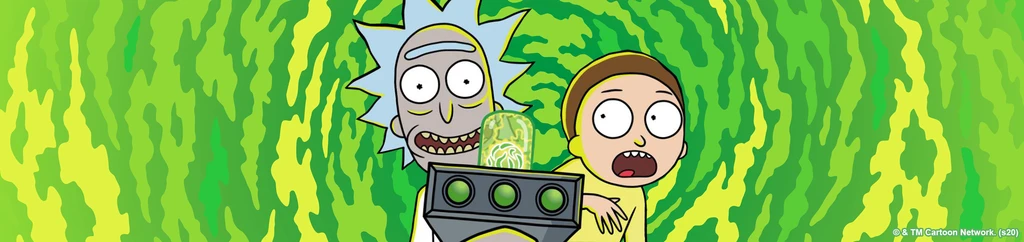


### TABLE OF CONTENTS

- [__1. Motivation__](#1.)
- [__2. Basic Stats__](#2.)
- [__3. Tools, theory and analysis__](#3.)
    - [3.1. <u>Communities</u>](#3.1.)
    - [3.2. <u>Centrality Analysis</u>](#3.2.)
    - [3.3. <u>Finding the “favourite words” of the Smith/Sanchez family</u>](#3.3.)
    - [3.4. <u>Wordclouds</u>](#3.4.)
    - [3.5. <u> Sentiment analysis of their words: how do they interact to each other? which sentiments do they express ?</u>](#3.5.)
    - [3.6. <u>Study Beth and Jerry marriage through seasons</u>](#3.6.)
    - [3.7. <u>Sentiment Analysis: Characters</u>](#3.7.)
    - [3.8. <u>Sentiment Analysis: Episode</u>](#3.8.)
    - [3.9. <u>Sentiment Analysis of Characters Through Episodes</u>](#3.9.)
- [__4. Discussion__](#4.)
- [__5. Contributions__](#5.)

---

<a id='1.'></a>
# 1. Motivation

*What is your dataset? Why did you choose this/these particular dataset(s)? What was your goal for the end user's?experience?*

Our dataset focuses on Rick and Morty characters and how they relate to each other, based on Wiki pages hyperlink references like we did in the Zelda study case. We're also considering characters' words through the analysis of transcripts, and characters' implication throughout episodes. 

We chose to study this universe because, first of all, we are all Rick and Morty show fans! Hence we felt very excited to apply everything we went through in this Social Graphs & Interactions journey to this series.

More seriously, although Rick and Morty can be considered as a childhish crazy cartoon, tinged with an absurd humour and an assumed nonsense, we have to keep in mind that it is an adult series that deals with dark but deeply human topics, like loneliness, abandon, familial relationships, divorce or the death of loved ones.

Therefore, in the following study and with our website, we wanted to honour the great imagination of the two creators, Justin Roiland & Dan Harmon, by trying to better understand as the complexity as the richness of the social relationships depicted through Rick and Morty universe. 

**We do discuss all of our results on our website. Please refer to it to get a deeper interpretation or analysis of what you find here!**

<a id='2.'></a>
# 2. Basic Stats

*Write about your choices in data cleaning and preprocessing. Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)*

As previoulsy mentioned, our data is a combination of mainly the Wiki Rick and Morty page and an API that we used to extract additional information. First of all, we extracted the data from the Wiki page by using BeautifulSoup Python package. Once we obtained anything useful from the Wiki pages we tried to request data by using an API (you can try to make a call on your browser to check the format: https://rickandmortyapi.com/api/character).
We had a lot of issues when we tried to combined the two sources, since the API not only had quite more amount of data comparing to the Wiki page but also some of the names differed. For the transcripts and the episodes we used the dataset built by Andrada Olteanu from Kaggle. Then we completed this initial database by downloading all available episode's transcripts on the Rick and Morty Wiki fandom. However, we did not stop there. We obtained IMDB rating and ranking for the episodes.
You can find more information on our website in the section `Collect the Data, Morty`.
In order to manipulate text data we used regex, we had different patterns to process for instance we searched for all references ("[[<aCharacter>]]") in the source code of the studied character Wiki page. Regex had a key role when we trying to parse the transcript of the episodes.



In [1]:
# import modules
import pandas as pd
import random as rd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import codecs
import networkx as nx
import urllib.request
import json
import nltk 
import matplotlib.pyplot as plt
import community
import fa2
from nltk.tokenize import RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from os import listdir
from nltk.corpus import PlaintextCorpusReader
from os.path import isfile, join
from nltk.tokenize import WordPunctTokenizer
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
from IPython.display import display
from scipy import stats
from collections import Counter
from community import community_louvain
from matplotlib.pyplot import figure
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


pd.options.mode.chained_assignment = None 
plt.rcParams["figure.figsize"] = (20,10)
sns.set()

In [2]:
# import our data
df_characters = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/RaM_characters_wRelationsAndAttributes_final.csv")
df_episodes = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/RaM_episodes.csv")
df_transcripts = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/transcripts/RickAndMortyScripts.csv")

# Dataframe of Characters
df_char_degr = pd.read_csv('https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/df_characters_with_attr_and_communities.csv')
df_nrc = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/NRC.csv")
df_nrc_01 = pd.read_csv('https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/lexicons/NRC_sentiment_lexicon.csv')



In [124]:
# toolbox
def rev_dict(aDict, rev=True):
    return dict(sorted(aDict.items(), reverse=rev, key=lambda x:x[1]))

In [125]:
# building the graph
def add_node(row, aGraph):
    """ Add the node given in row to global network """
    aGraph.add_node(row.Name, species=row.Species, origin=row.Origin, gender = row.Gender, status = row.Status)

def add_edges(row, aGraph):
    """ Add all edges which concern given character in row"""
    char_name = row.Name
    char_relations = ast.literal_eval(row.Relations)
    for aTargetRelation in char_relations:
        aGraph.add_edge(char_name,aTargetRelation)


In [126]:
# Create the associate graph with all attributes : role, race, genre, contentLength
G = nx.DiGraph()
_ = df_characters.apply(add_node, args=(G,), axis=1)
_ = df_characters.apply(add_edges, args=(G,), axis=1)

# Extract the Giant Connected Component, GCC
GCC = nx.weakly_connected_components(G)
GCC = list(GCC)
GCC.sort(key=len)
concerned_nodes = GCC[-1]
GCC = G.subgraph(concerned_nodes).copy()
G_copy = GCC.copy()

# make G undirected
GU = G.to_undirected()

In [127]:
print('Number of nodes:', G.number_of_nodes())

Number of nodes: 514


In [128]:
print('Number of edges:', G.number_of_edges())

Number of edges: 1891


In [129]:
# store in and out degree
df_characters['in_degree'] = df_characters['Name'].map(dict(G.in_degree))
df_characters['out_degree'] = df_characters['Name'].map(dict(G.out_degree))

In [130]:
df_characters

Name                                          Hyperlink  \
0      Abandoned Jerrys  https://rickandmorty.fandom.com/wiki/Abandoned...   
1    Abrodolph Lincoler  https://rickandmorty.fandom.com/wiki/Abrodolph...   
2                  Adam          https://rickandmorty.fandom.com/wiki/Adam   
3      Adjudicator Rick  https://rickandmorty.fandom.com/wiki/Adjudicat...   
4             Afro Rick     https://rickandmorty.fandom.com/wiki/Afro_Rick   
..                  ...                                                ...   
509          Birdperson    https://rickandmorty.fandom.com/wiki/Birdperson   
510         Memory Rick   https://rickandmorty.fandom.com/wiki/Memory_Rick   
511               Chris         https://rickandmorty.fandom.com/wiki/Chris   
512             Cynthia       https://rickandmorty.fandom.com/wiki/Cynthia   
513               Glenn         https://rickandmorty.fandom.com/wiki/Glenn   

                                             Relations  \
0                                      ['Jerry Smith']   
1     ['Rick Sanchez', 'Brad', 'Morty Smith', 'Nancy']   
2                                                   []   
3                                       ['Evil Morty']   
4    ['Rick Sanchez', 'Morty Smith', 'Council of Ri...   
..                                                 ...   
509  ['Rick Sanchez', 'Tammy Guterman', 'Squanchy',...   
510  ['Birdperson', 'Rick Sanchez (Replacement Dime...   
511  ['Chris (The Ricks Must Be Crazy)', 'Shleemypa...   
512  ['Cynthia (Rixty Minutes)', 'Prince Nebulon', ...   
513  ['Gromflomites', 'Glenn (Rixty Minutes)', 'Mor...   

                                Species                  Origin      Gender  \
0                                 Human                   Earth        Male   
1                                 Human                 unknown        Male   
2                              Humanoid        Narnia Dimension        Male   
3                                 Human                 unknown        Male   
4                                 Human  Earth (Dimension E-33)        Male   
..                                  ...                     ...         ...   
509                         Bird Person              Bird World        Male   
510  Sentient Memory (Human appearance)       Birdperson's mind        Male   
511                               Alien                 unknown  Genderless   
512                            Zigerion                Zigerion      Female   
513                         Gromflomite                 unknown        Male   

      Status  in_degree  out_degree  \
0      Alive          0           1   
1    unknown          5           4   
2       Dead          0           0   
3       Dead          1           1   
4      Alive          2           7   
..       ...        ...         ...   
509    Alive         24           8   
510    Alive          1           4   
511     Dead          3           2   
512     Dead          1           3   
513     Dead          1           4   

                                             NRC_score  NRC_words  
0                                                 None        NaN  
1                                                 None        NaN  
2                                                 None        NaN  
3                                                 None        NaN  
4                                                 None        NaN  
..                                                 ...        ...  
509  {'positive': 24, 'negative': 16, 'trust': 13, ...       42.0  
510                                               None        NaN  
511                                               None        NaN  
512  {'positive': 3, 'negative': 3, 'trust': 3, 'an...        6.0  
513  {'positive': 1, 'negative': 1, 'trust': 0, 'an...        2.0  

[514 rows x 11 columns]

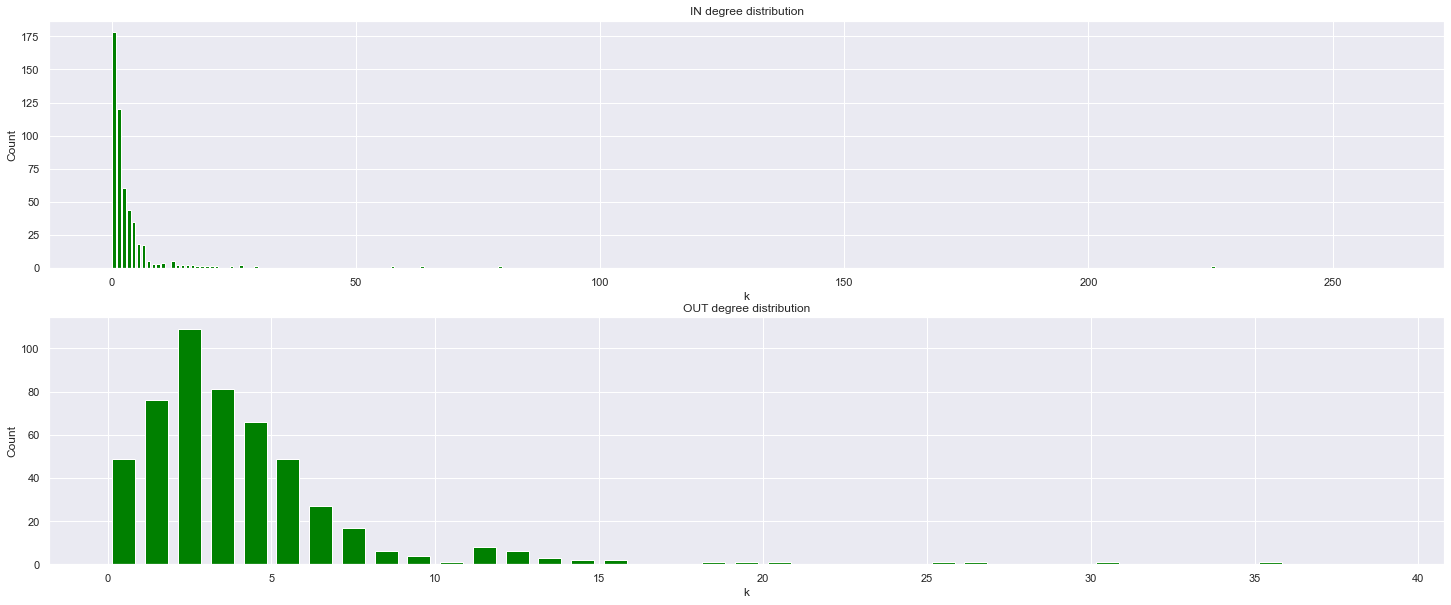

In [131]:
plt.figure(figsize=(25,10))
colors = ['green', 'blue', 'lime'] 

plt.subplot(211)
data = np.array(list(dict(G.in_degree()).values()), dtype=float)
plt.hist(data, bins=range(max(list(dict(G.in_degree()).values()))-min(list(dict(G.in_degree()).values()))), rwidth=0.7, color="green")
plt.title("IN degree distribution")
plt.ylabel("Count")
plt.xlabel("k")

plt.subplot(212)
plt.title("OUT degree distribution")
plt.ylabel("Count")
plt.xlabel("k")
data = np.array(list(dict(G.out_degree()).values()), dtype=float)
plt.hist(data, bins=range(max(list(dict(G.out_degree()).values()))-min(list(dict(G.out_degree()).values()))), rwidth=0.7, color="green")


plt.show()

In [132]:
G_to_draw = GU.copy()
G_copy = GCC.copy()
G_to_draw.remove_edges_from(nx.selfloop_edges(G_to_draw)) # remove self loops characters pointing to themselves 

In [133]:
# set node color and size 
get_color = {'Female':'orange','Genderless':'blue', "Male": "purple", "Both": "green"}

colors_list, size_list = [], []
for nodeName, nodeAttributes in list(G_to_draw.nodes(data=True)):
    # color nodes according to the role)
    colors_list.append(get_color[nodeAttributes['gender']])
    # scale node-size according to degree
    size_list.append(G_to_draw.degree(nodeName))

size_list = list(20*np.array(size_list))
d = dict(GU.degree)

100%|██████████| 2000/2000 [00:26<00:00, 75.19it/s] 


BarnesHut Approximation  took  3.37  seconds
Repulsion forces  took  21.61  seconds
Gravitational forces  took  0.16  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.76  seconds


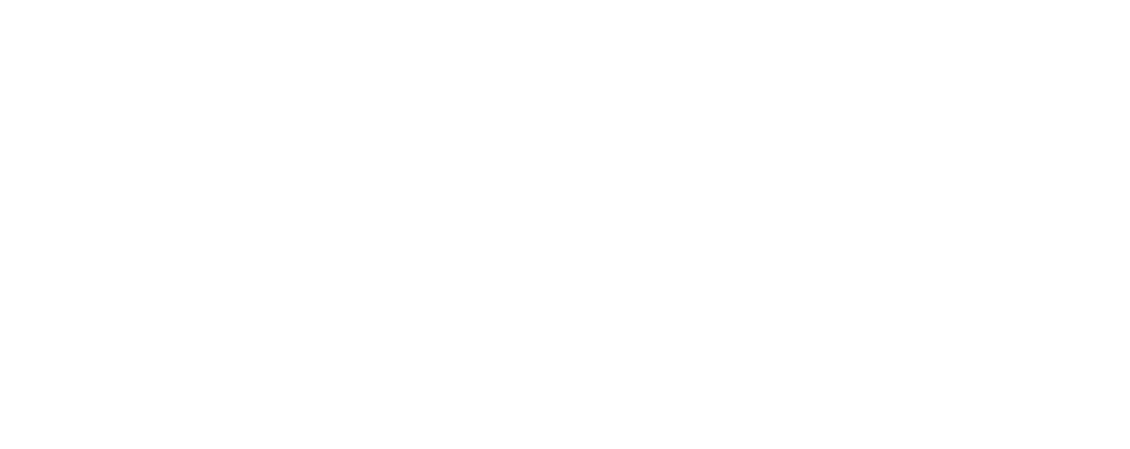

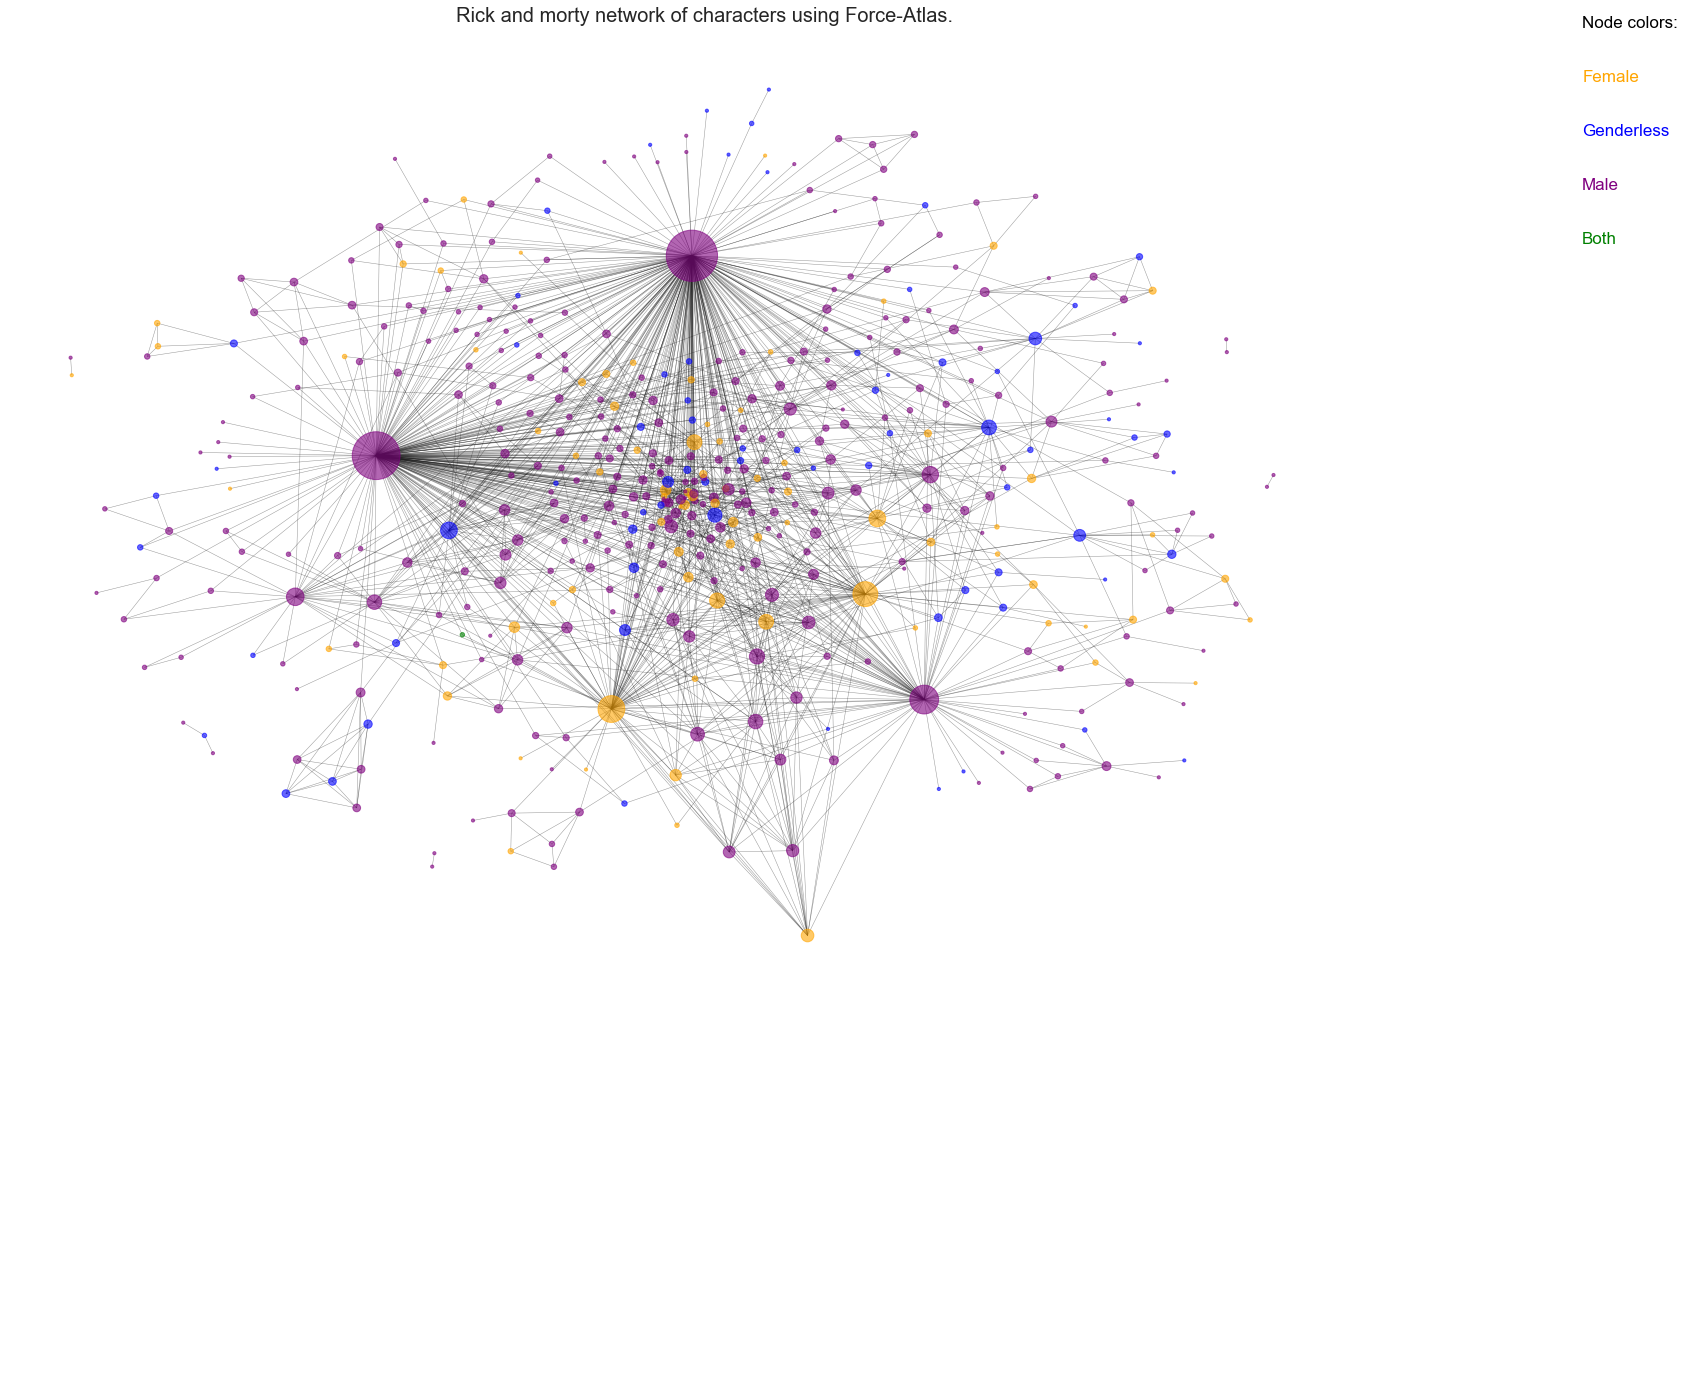

In [134]:
limits = plt.axis("off") 

forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False, 
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=70.0,
                        strongGravityMode=False,
                        gravity=400.0,

                        # Log
                        verbose=True)

# get node positions from force atlas
pos = forceatlas2.forceatlas2_networkx_layout(G_to_draw, pos=None, iterations=2000)

# plot network
plt.figure(figsize = [25, 25])

nx.draw_networkx_nodes(G_to_draw,pos=pos, node_size=[v*10  for v in d.values()], node_color=colors_list, alpha=0.6)
nx.draw_networkx_edges(G_to_draw,pos=pos, width=0.5, alpha=0.45, arrows=False)

plt.axis('off')

y = 0.88 # This is the starting y position for the figure legend
plt.figtext(1, y, 'Node colors:', size = 17, color = 'black')
colots_node = ['orange','blue', "purple", "green"]
role_node = ['Female', 'Genderless','Male', "Both"]
y -= 0.03
for i in range(4):
    plt.figtext(1, y, str(role_node[i]), size = 17, color = colots_node[i])
    y -= 0.03

plt.title("Rick and morty network of characters using Force-Atlas.", fontsize=20)

plt.show()

Text(0.5, 1.0, 'Scatter plot of in VS out degree for all characters')

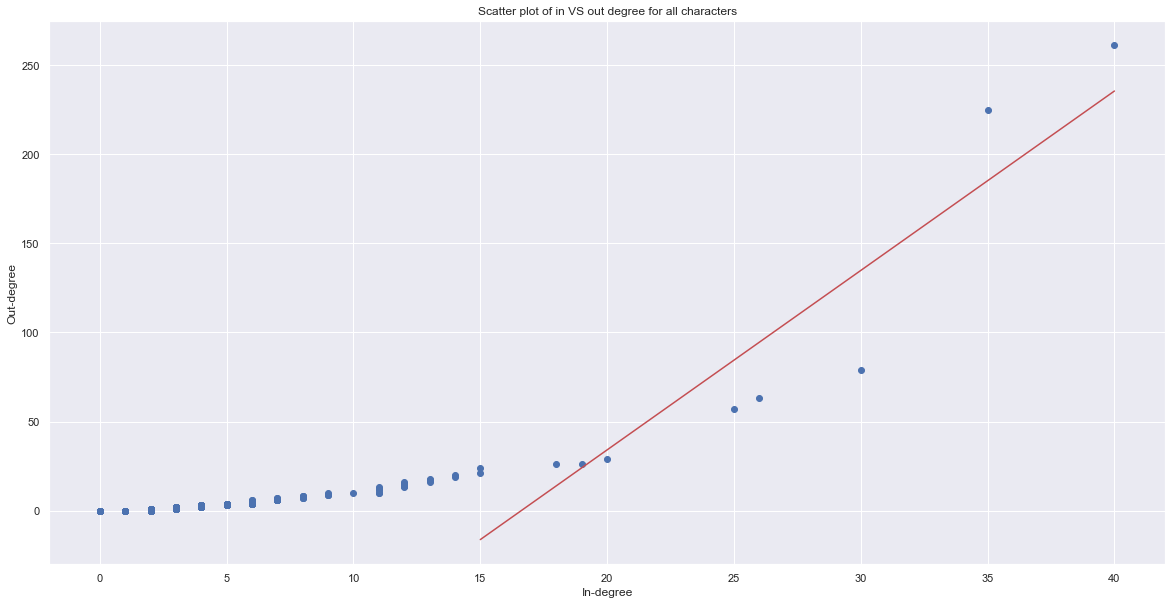

In [15]:
all_nodes = list(G.nodes())
x, y = [G.out_degree(aNode) for aNode in all_nodes],[G.in_degree(aNode) for aNode in all_nodes]
x.sort()
y.sort()
x_l, y_l = x[-9:], y[-9:]
res = stats.linregress(x_l, y_l)
x_l = np.array(x_l)

plt.plot(x, y, 'o', label='original data')
plt.plot(x_l, res.intercept + res.slope*x_l, 'r', label='fitted line')
plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.title('Scatter plot of in VS out degree for all characters')

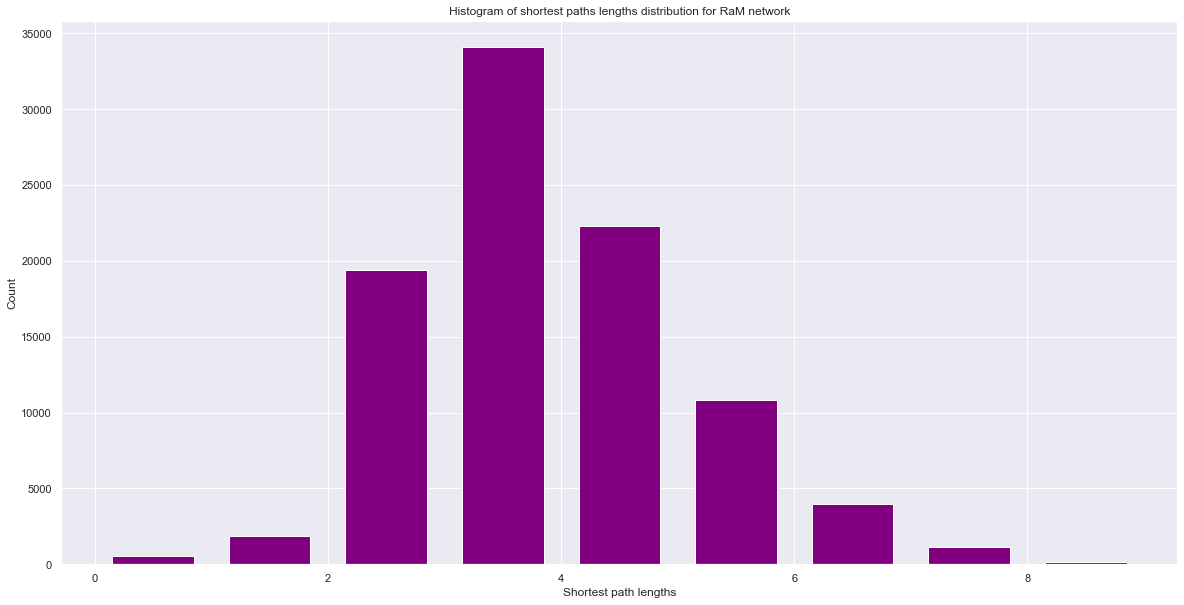

In [16]:
all_shortest_path_lengths = [int(e) for subDict in list(dict(nx.all_pairs_shortest_path_length(G)).values()) for e in list(subDict.values()) ]
plt.hist(all_shortest_path_lengths, bins=max(all_shortest_path_lengths)-min(all_shortest_path_lengths), color='purple', rwidth=0.7,)
plt.title('Histogram of shortest paths lengths distribution for RaM network')
plt.xlabel('Shortest path lengths')
plt.ylabel('Count')
plt.show()

In [136]:
fail_friendship_paradox = []
for _ in range (1000):
    i_rd = rd.choice(list(G_copy.nodes))
    d_rd = G.degree[i_rd]
    neighbors_list = list(G.neighbors(i_rd))
    neighbors_degree_list = [G.degree(neighbor) for neighbor in neighbors_list]
    avg_degree = np.mean(neighbors_degree_list)
    if avg_degree <= d_rd:
        fail_friendship_paradox.append((d_rd,avg_degree))
print(f"Friendship paradox works {100 - round(100*len(fail_friendship_paradox)/1000,2)}% of times")

Friendship paradox works 97.3% of times


<a id='3.'></a>
# 3. Tools, theory and analysis

<a id='3.1.'></a>
## 3.1. Communities 

*In network science we call a community a group of nodes that have a higher likelihood of connecting to each other than to nodes from other communities. Firstly, we created communities using the Louvain algorithm which looks for "small" communities by optimizing modularity in a local way. In addition, we create communities based on the node's attributes in order to explore a bit more our data. It is obvious that the modularity obtained in the communities that we created based on the node's attributes is smaller than the modularity of the Louvain algorithm*

In [18]:
best_partition = community_louvain.best_partition(GU)


def get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph):
    """ Get all subgraphs {id:subgraph} based on the dictionary of {node:id} (nodes_attributes_dic) """
    communities_list = list(set(list(nodes_attributes_dic.values())))
    community_partition = { aCommunity:None for aCommunity in communities_list }
    for aCommunity in communities_list:
        community_characters_list = [ k for k,v in nodes_attributes_dic.items() if v == aCommunity ]
        community_subgraph = aGraph.subgraph(community_characters_list).copy()
        community_partition[aCommunity] = community_subgraph
    return community_partition

best_partition_subgraphs = get_partition_from_nodes_attributes(best_partition, G)

print(f"The partition based on Louvain-algorithm detects {len(list(best_partition_subgraphs.keys()))} communities.")


The partition based on Louvain-algorithm detects 60 communities.


In [19]:
print(f"The Louvain algorithm found {len(set(best_partition.values()))} communities for tthe network.\
The modularity is {community.modularity(best_partition, GU):.2f}")

The Louvain algorithm found 60 communities for tthe network.The modularity is 0.47


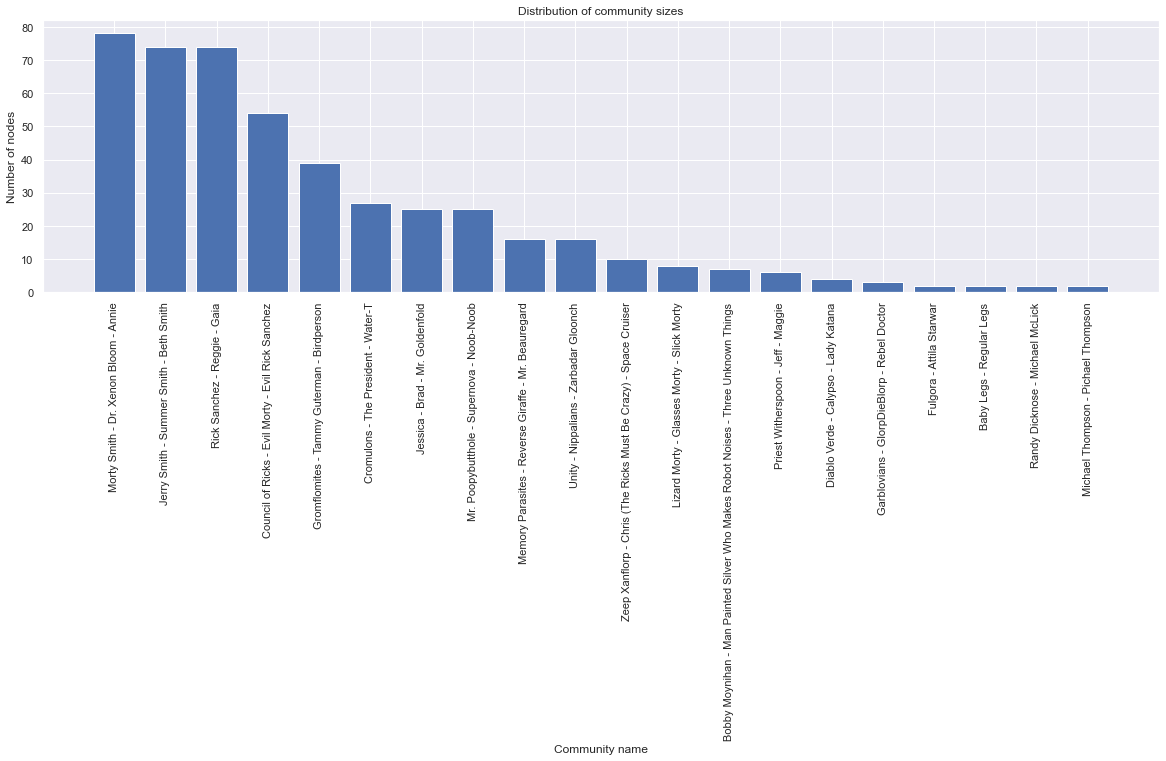

In [20]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in best_partition_subgraphs.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

# get the size of each community
best_partition_counter = dict(Counter(list(best_partition.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))
best_partition_counter = {key:val for key, val in best_partition_counter.items() if val != 1}

# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values())
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes")
plt.show()


In [21]:
def get_partition_from_nodes_attributes(nodes_attributes_dic, aGraph):
    """ Get all subgraphs {id:subgraph} based on the dictionary of {node:id} (nodes_attributes_dic) """
    communities_list = list(set(list(nodes_attributes_dic.values())))
    community_partition = { aCommunity:None for aCommunity in communities_list }
    for aCommunity in communities_list:
        community_characters_list = [ k for k,v in nodes_attributes_dic.items() if v == aCommunity ]
        community_subgraph = aGraph.subgraph(community_characters_list).copy()
        community_partition[aCommunity] = community_subgraph
    return community_partition

def get_modularity(communities_dic, aGraph):
    """ Get the modularity M of the partition of a graph aGraph given through the dictionary of subgraphs communities_dic """
    L = aGraph.number_of_edges()
    M = 0
    for _, aCommunityGraph in communities_dic.items():
        Lc = aCommunityGraph.number_of_edges()
        kc = sum(list(dict(aCommunityGraph.degree).values()))
        M += (Lc/L - (kc/(2*L))**2)
    print("Modularity M = {}".format(round(M, 2)))
    return M

species_dict = pd.Series(df_characters.Species.values, index=df_characters.Name).to_dict()

part_comm_based_on_species = get_partition_from_nodes_attributes(species_dict, G)
print(f"The partition based on species detects {len(list(part_comm_based_on_species.keys()))} communities.")


print("For the partition based on species:")
species_partition_modularity = get_modularity(part_comm_based_on_species, G)

The partition based on species detects 34 communities.
For the partition based on species:
Modularity M = 0.35


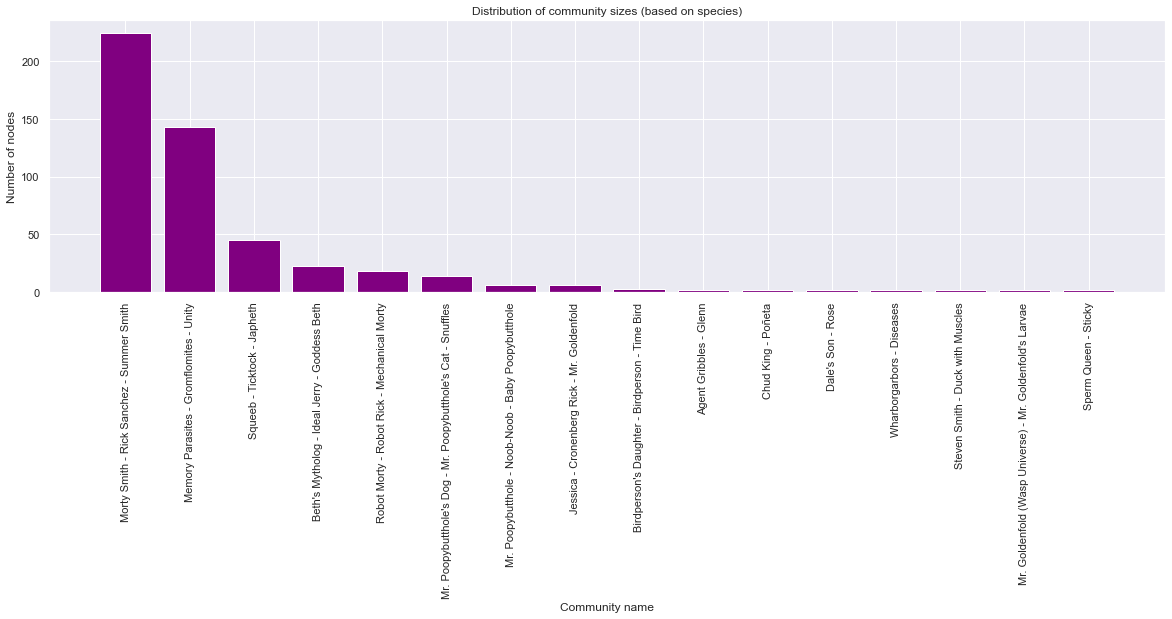

In [22]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in part_comm_based_on_species.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

# get the size of each community
best_partition_counter = dict(Counter(list(species_dict.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))

best_partition_counter = {key:val for key, val in best_partition_counter.items() if val != 1}

best_partition_counter = {key:val for key, val in best_partition_counter.items() if key != 'unknown'}


# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values(), color='purple')
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes (based on species)")
plt.show()

In [23]:
origin_dict = pd.Series(df_characters.Origin.values, index=df_characters.Name).to_dict()

part_comm_based_on_origin = get_partition_from_nodes_attributes(origin_dict, G)
print(f"The partition based on origin detects {len(list(part_comm_based_on_origin.keys()))} communities.")


print("For the partition based on species:")
species_partition_modularity = get_modularity(part_comm_based_on_origin, G)

The partition based on origin detects 66 communities.
For the partition based on species:
Modularity M = 0.29


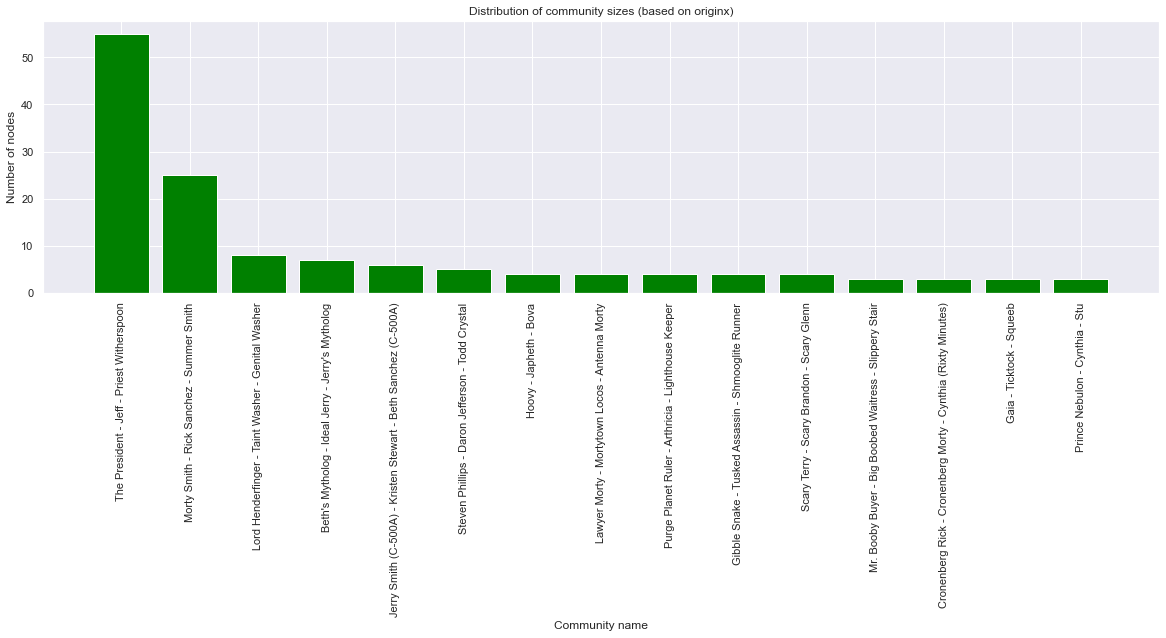

In [24]:
# naming each community based on their 3 most connected characters
communities_names = {}
for anId, aSubGraph in part_comm_based_on_origin.items():
    top3degree = list(dict(sorted(dict(aSubGraph.degree()).items(),reverse=True, key=lambda x:x[1])[:3]).keys())
    name = ' - '.join(top3degree)
    communities_names[anId]=name

# get the size of each community
best_partition_counter = dict(Counter(list(origin_dict.values())))
best_partition_counter = dict(sorted(best_partition_counter.items(), reverse=True, key=lambda x:x[1]))
best_partition_counter = {key:val for key, val in best_partition_counter.items() if val > 2 }
best_partition_counter = {key:val for key, val in best_partition_counter.items() if key != 'unknown'}


# plot histogram
plt.figure(figsize=(20,5))
communities_labels = [communities_names[anId] for anId in list(best_partition_counter.keys())]
plt.bar(communities_labels, best_partition_counter.values(), color='green')
plt.xticks(communities_labels, rotation=90)
plt.xlabel('Community name')
plt.ylabel('Number of nodes')
plt.title("Distribution of community sizes (based on originx)")
plt.show()

<a id='3.1.'></a>
## 3.2. Centrality Analysis

### Betweeness centrality

In [25]:
N=10

# betweeness centrality
betweeness_centrality_dict = nx.betweenness_centrality(G)
betweeness_centrality_dict = dict(sorted(betweeness_centrality_dict.items(), reverse=True, key=lambda item: item[1]))
print(N, "most central characters according to betweeness centrality : ")
for i in range (N):
    character_name_i = list(betweeness_centrality_dict.keys())[i]
    print(f"- {character_name_i} : {betweeness_centrality_dict[character_name_i]}")

10 most central characters according to betweeness centrality : 
- Rick Sanchez : 0.18093429831411695
- Morty Smith : 0.11162821169399144
- Jerry Smith : 0.04522779652583261
- Beth Smith : 0.031072139172692633
- Summer Smith : 0.027309212023106
- Memory Parasites : 0.024339875242522315
- Council of Ricks : 0.01628576117006055
- Sleepy Gary : 0.015257961365860578
- Gromflomites : 0.014251373288534342
- Mr. Poopybutthole : 0.013336208744391759


### Eigenvector centrality

In [26]:
eigenvector_centrality_dict = nx.algorithms.centrality.eigenvector_centrality(G)
eigenvector_centrality_dict = dict(sorted(eigenvector_centrality_dict.items(), reverse=True, key=lambda item: item[1]))
print(N,"most central characters according to eigenvector centrality : ")
for i in range (N):
    character_name_i = list(eigenvector_centrality_dict.keys())[i]
    print(f"- {character_name_i} : {eigenvector_centrality_dict[character_name_i]}")

10 most central characters according to eigenvector centrality : 
- Morty Smith : 0.3849246053437887
- Rick Sanchez : 0.3780159256209327
- Summer Smith : 0.28444539545797176
- Jerry Smith : 0.27897535624443803
- Beth Smith : 0.26562871014254896
- Morty Jr. : 0.2103325155302278
- Diane Sanchez : 0.20910509293133706
- Joyce Smith : 0.18450901321391275
- Leonard Smith : 0.1735347170368146
- Unnamed Uncle : 0.16115967506660234


### Assortativity

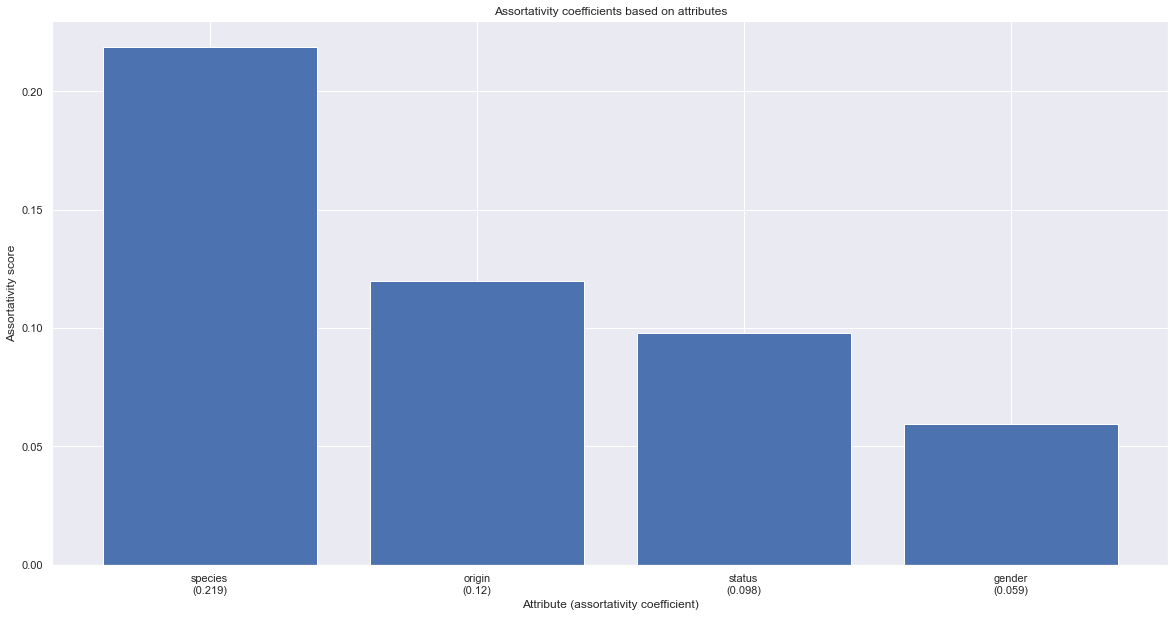

In [27]:
assort_coeffs = {}
attributes_list = ['species','gender','origin','status']

for a in attributes_list:
    assort_coeffs[a] =  nx.algorithms.assortativity.attribute_assortativity_coefficient(G, a)

assort_coeffs = rev_dict(assort_coeffs)

plt.bar(list(range(len(attributes_list))), assort_coeffs.values())
plt.xticks(list(range(len(attributes_list))), [k+f'\n({round(assort_coeffs[k],3)})' for k in assort_coeffs.keys()])
plt.xlabel("Attribute (assortativity coefficient)")
plt.ylabel('Assortativity score')
plt.title("Assortativity coefficients based on attributes")
plt.show()

<a id='3.3.'></a>
## 3.3.  Finding the “favourite words” of the Smith/Sanchez family

In [28]:
# create a text with lines of for each character

family_list = {
    'Rick':'Rick Sanchez',
    'Morty':'Morty Smith',
    'Beth':'Beth Smith',
    'Jerry':'Jerry Smith',
    'Summer':'Summer Smith'}

dict_text = {k:"" for k in family_list.keys()}

def add_line_to_text(aRow):
    if aRow['name'] in family_list:
        dict_text[aRow['name']] += (' '+str(aRow['line']))

_ = df_transcripts.apply(add_line_to_text, axis=1)



In [29]:
rev_family_list = {v:k for k,v in family_list.items()}

In [31]:
pages_path = 'character_words'
all_files = [f for f in listdir(pages_path) if isfile(join(pages_path, f))]

stopwords = STOPWORDS
# tokenization factory
tk = WordPunctTokenizer()
# lemmatization factory
lm = nltk.WordNetLemmatizer()

# for each character
for aFile in all_files:
    # Read the file containing the character's page description.
    character_page = open(pages_path+'/'+aFile, encoding="utf-8").read() 
    # Set everything to lower case.
    character_page = character_page.lower()
    # Exclude characters names, BEFORE tokenisation
    for aCharacterName in family_list.keys():
        character_page = character_page.replace(aCharacterName.lower(),'')
    # Tokenize your text
    character_page = tk.tokenize(character_page)
    # Exclude punctuation and stop words
    character_page = [aToken for aToken in character_page if aToken.isalnum() and aToken not in stopwords]
    # Lemmatize words
    character_page = [ lm.lemmatize(w) for w in character_page ]
    # Remove words with less than 2 letters
    character_page = [ w for w in character_page if len(w)>2]
    # Transform list into list separated by spaces
    character_page = ''.join([str(elem)+' ' for elem in character_page])

In [32]:
# create NLTK objects: Corpus and Text
corpus_root = 'character_words_tokens'
familyCorpus = PlaintextCorpusReader(corpus_root, all_files)
familyText = nltk.Text(familyCorpus.words())

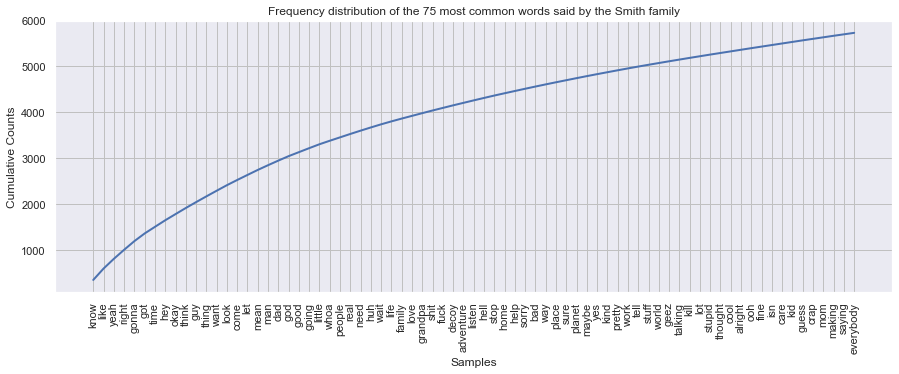

In [33]:
# get the freq distribution of tokens
fdist_family = nltk.FreqDist(familyText)
nb_words = 75
fdist_family.most_common(nb_words)
plt.figure(figsize=(15,5))
plt.title(f'Frequency distribution of the {nb_words} most common words said by the Smith family')
fdist_family.plot(nb_words, cumulative=True)
plt.show()

In [34]:
def dic_reverse_sort(aDict, rev=True):
    return dict(sorted(aDict.items(), reverse=rev, key=lambda x:x[1]))

In [35]:
familyText.similar('family')

dad know life build god important old dunno day far dressed


In [36]:
familyText.common_contexts(['family','important'])
familyText.common_contexts(['family','life'])

think_love
time_friend


In [37]:
# study each character's words
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}
char_documents

{'Rick Sanchez': <Text: gotta come jus gotta come got surprise come...>,
 'Morty Smith': <Text: going middle night talking tugging hard yeah great...>,
 'Beth Smith': <Text: getting sick told practice kiss living room pillow...>,
 'Jerry Smith': <Text: new episode singing tonight guy think gonna best...>,
 'Summer Smith': <Text: god head food going puke maybe night grandpa...>}

In [38]:
# who is the most talkative
most_talkative = dic_reverse_sort({k:len(t)/len(familyText) for k,t in char_documents.items()})
most_talkative

{'Rick Sanchez': 0.5007924827351976,
 'Morty Smith': 0.21895165855315296,
 'Jerry Smith': 0.12702366127023662,
 'Summer Smith': 0.07902184988112759,
 'Beth Smith': 0.0742103475602853}

In [39]:
nb_lines = dic_reverse_sort({k:len(df_transcripts[df_transcripts.name == rev_family_list[k]]) for k,t in char_documents.items()})
nb_lines

{'Rick Sanchez': 1456,
 'Morty Smith': 1020,
 'Jerry Smith': 490,
 'Summer Smith': 381,
 'Beth Smith': 353}

In [40]:
char_colors = {'Rick Sanchez':'#95e4f0', 'Morty Smith':'#f7ecb0','Jerry Smith':'#6fde8b','Summer Smith':'#e895de','Beth Smith':'#e8a2a2'}

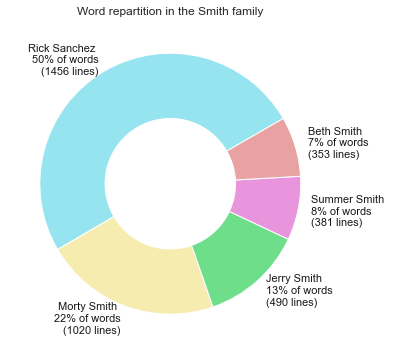

In [41]:
# plot most talkative : pie chart
plt.figure(figsize=(6,6))
font_color = 'k'
plt.pie(most_talkative.values(), 
           labels=['{} \n{}% of words\n({} lines)'.format(k,round(100*v),nb_lines[k]) for k,v in most_talkative.items()], 
           startangle=30, 
           wedgeprops=dict(width=.5), # For donuts
           colors=[char_colors[k] for k in most_talkative.keys()],
           textprops={'color':font_color})
plt.title("Word repartition in the Smith family")
plt.show()

In [42]:
# compare lexical diversities

# functions from Natural Language Processing with Python (NLPP), Chapter 1.4
def lexical_diversity(text):
    return len(set(text)) / len(text)

print("Overall lexical diversity: ", lexical_diversity(familyText))

compare_lexical_diversity = dic_reverse_sort({k:lexical_diversity(v) for k,v in char_documents.items()})
compare_lexical_diversity

Overall lexical diversity:  0.2345182837088192


{'Summer Smith': 0.5286532951289399,
 'Beth Smith': 0.528604118993135,
 'Jerry Smith': 0.4768270944741533,
 'Morty Smith': 0.3518614270941055,
 'Rick Sanchez': 0.3227082626879168}

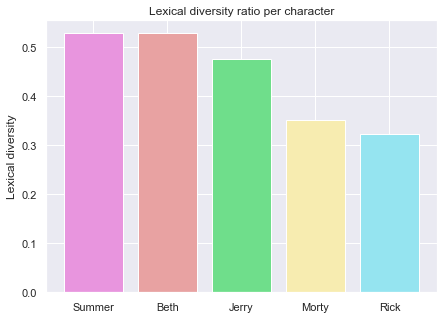

In [43]:
x = list(range(5))
plt.figure(figsize=(7,5))
plt.bar(x,compare_lexical_diversity.values(),color=[char_colors[k] for k in compare_lexical_diversity.keys()])
plt.xticks(x,[rev_family_list[k] for k in compare_lexical_diversity.keys()])
plt.title("Lexical diversity ratio per character")
plt.ylabel("Lexical diversity")
plt.show()

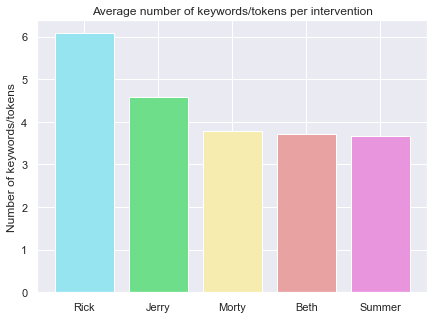

In [44]:
# tokens/nb of lines
most_talkative2 = dic_reverse_sort({k:len(t)/len(df_transcripts[df_transcripts.name == rev_family_list[k]]) for k,t in char_documents.items()})
most_talkative2

x = list(range(5))
plt.figure(figsize=(7,5))
plt.bar(x,most_talkative2.values(),color=[char_colors[k] for k in most_talkative2.keys()])
plt.xticks(x,[rev_family_list[k] for k in most_talkative2.keys()])
plt.ylabel('Number of keywords/tokens')
plt.title("Average number of keywords/tokens per intervention")

plt.show()

In [45]:
# get one document (of tokens) per character
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}

In [49]:
# compute the TC of each character
char_fdist = {aCharacter:nltk.FreqDist(aText) for aCharacter, aText in char_documents.items()}

def getTC(t, aFdist):
    """ Get the term count of a term t in a document d whose we already computed the frequency distribution aFdist"""
    return aFdist[t]

def find_top_5_terms(aText):
    """ Find the 5 most common terms in the text """
    fdist = nltk.FreqDist(aText)
    fdist = dict(fdist.most_common(5))
    return {k:v/len(aText) for k,v in fdist.items()}

# find the top 5 terms for each character based on TC
family_top_5_terms = {aChar:find_top_5_terms(aCharText) for aChar, aCharText in char_documents.items()}

# print results
print("The top 5 terms for each character is:\n")
for aChar, aListOfTerms in family_top_5_terms.items():
    print("- {} : {}".format(aChar, list(aListOfTerms.keys())))

The top 5 terms for each character is:

- Rick Sanchez : ['know', 'gonna', 'right', 'like', 'yeah']
- Morty Smith : ['know', 'like', 'right', 'yeah', 'gonna']
- Beth Smith : ['dad', 'know', 'okay', 'like', 'want']
- Jerry Smith : ['know', 'like', 'hey', 'guy', 'okay']
- Summer Smith : ['grandpa', 'god', 'yeah', 'like', 'dad']


In [50]:
# compute the IDF for every word
def getIDF(t,D, fdist_dic):
    """ Get the inverse document frequency of a term t among the corpus D whose we give the frequency distributions fdist_dic """
    N = len(D)
    nb_texts_with_term = 1 + sum([1 if getTC(t,fdist_dic[a]) else 0 for a in list(D.keys()) ])
    return np.log10(N/nb_texts_with_term)

all_words_IDFs = {aTerm:getIDF(aTerm, char_documents, char_fdist) for aTerm in familyText}

In [51]:
# compute TC-IDF
def getTC_IDF(t,aFdist):
    """ get the TC*IDF for a term t, a document d from a corpus D (here, a dictionary of Texts) """
    return getTC(t, aFdist) * all_words_IDFs[t]

family_TC_IDF = {aChar:{aTerm:getTC_IDF(aTerm, char_fdist[aChar]) for aTerm in aText } for aChar,aText in char_documents.items() }
family_TC_IDF_sorted = {aChar:dict(sorted(aTCIDF_dic.items(), reverse=True, key=lambda x:x[1])) for aChar, aTCIDF_dic in family_TC_IDF.items()}

# print results
print("The top 5 terms based on TC*IDF for each character is:\n")
for aChar, aTC_IDF_dic in family_TC_IDF_sorted.items():
    print("- {} : {} (nb_tokens={})".format(aChar, list(aTC_IDF_dic)[:5], len(list(aTC_IDF_dic) )))

The top 5 terms based on TC*IDF for each character is:

- Rick Sanchez : ['sauce', 'number', 'bunch', 'season', 'piece'] (nb_tokens=2855)
- Morty Smith : ['ohh', 'duane', 'geez', 'ohhhh', 'bawk'] (nb_tokens=1361)
- Beth Smith : ['surgeon', 'cling', 'performing', 'surgery', 'davin'] (nb_tokens=693)
- Jerry Smith : ['apple', 'pluto', 'tru', 'award', 'potato'] (nb_tokens=1070)
- Summer Smith : ['drum', 'needful', 'bluffing', 'nancy', 'ethan'] (nb_tokens=738)


<a id='3.4.'></a>
## 3.4.  Wordclouds

In [52]:
def plot_wordcloud(chosen_element, documents_dic, TC_IDF_dic, aMaskFileName, aFigure):
    """ 
    Generate N wordclouds (based on given chosen_elements) using 
    - documents_dic {aKey:aDocument},
    - TC_IDF_dic {aKey{aWord:aScore}},
    in the matplotlib.pyplot Figure (aFigure) with a fancy mask (aMaskFileName) if wanted
    """
    if aMaskFileName != None:
        mask = np.array(Image.open(aMaskFileName))
    
    # Adjust the number of occurrences of each word based on TC-IDF
    list_to_wordcloud = []
    for aTerm in list(documents_dic[chosen_element]):
        multiplicator = round(TC_IDF_dic[chosen_element][aTerm])
        list_to_wordcloud = list_to_wordcloud + multiplicator*[aTerm]
        
    # Generate a word cloud image
    if aMaskFileName != None:
        wordcloud = WordCloud(background_color="white", mask=mask, collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        # create coloring from image
        image_colors = ImageColorGenerator(mask)
        aFigure.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        wordcloud = WordCloud(background_color="white", collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        aFigure.imshow(wordcloud, interpolation='bilinear')   
    aFigure.set_title(chosen_element, size=15)
    aFigure.axis("off")

In [53]:
# get masks for plots
url_base_masks = "masks/"
all_masks = ["rick_blue.png", "morty_yellow.png", "beth_red.png", "jerry_green.png", 'summer_pink.png']
all_masks = [ url_base_masks+aMaskFileName for aMaskFileName in all_masks ]

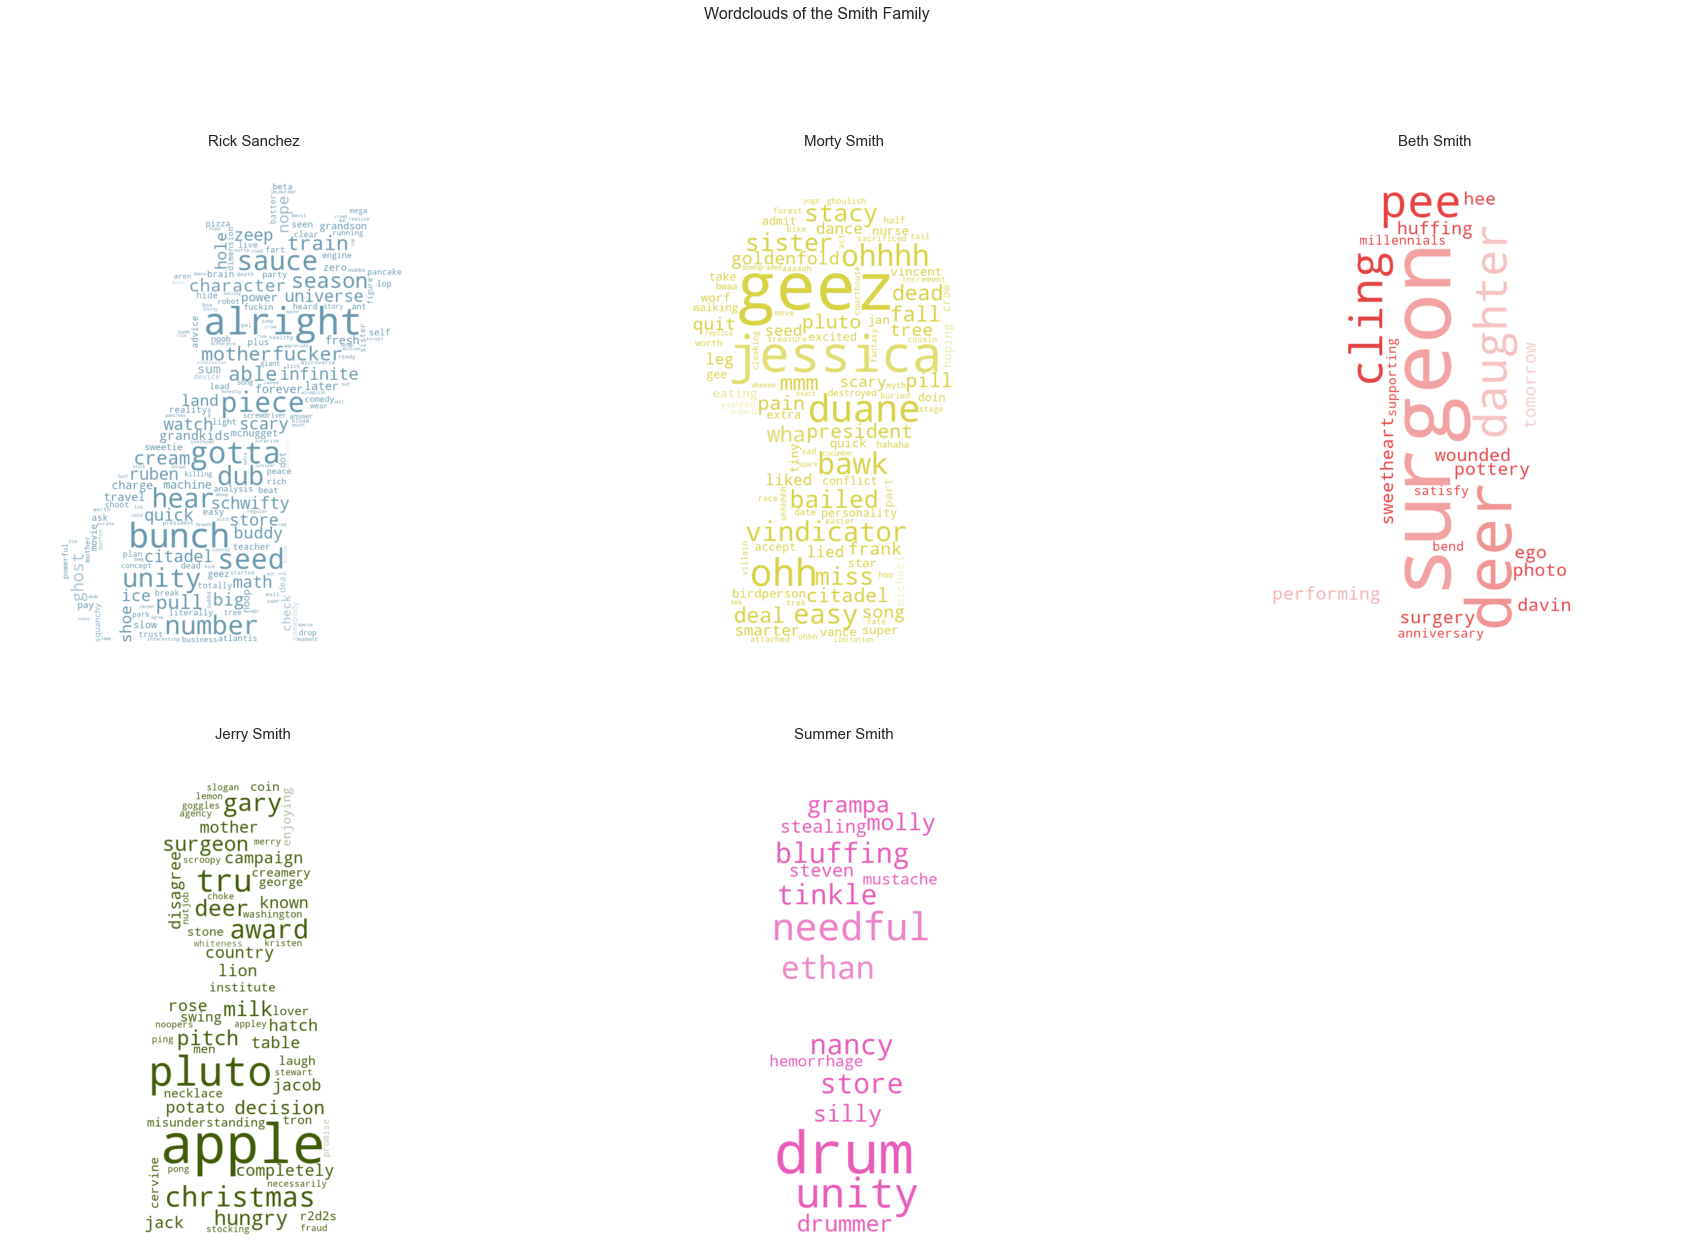

In [54]:
# plot wordclouds
fig, axes = plt.subplots(2,3,figsize=(30,20), subplot_kw={'xticks':[], 'yticks':[]})
fig.suptitle("Wordclouds of the Smith Family", fontsize=16)

for i,ax in enumerate(axes.flat):
    if i<5:
        plot_wordcloud(list(family_list.values())[i], char_documents, family_TC_IDF, all_masks[i], ax)
    else:
        ax.set_visible(False)
plt.show()

In [60]:
def get_50_most_frequent_bigrams_not_stopwords(aText, language = 'english', top_nb = 50):
    """Get  the 50 most most frequent bigrams of a text that are not stopwords. 
    By default, the text is in English"""
    # get the stopwords list in given language
    stopwords = nltk.corpus.stopwords.words(language)
    # drop stopwords from text and punctuation
    content = nltk.Text([w for w in aText if w.lower() not in stopwords and w.isalnum()])
    # get bigrams
    bigrams_list = list(nltk.bigrams(content))
    # compute frequency distribution for bigrams
    fdist_bigrams = nltk.FreqDist([a+' '+b for (a,b) in bigrams_list])
    # return 50 most common bigrams
    return fdist_bigrams.most_common(top_nb)


In [61]:
for aCharacter in family_list.values():
    print("For "+aCharacter+' : ')
    print(get_50_most_frequent_bigrams_not_stopwords(char_documents[aCharacter], top_nb=5))

For Rick Sanchez : 
[('look like', 19), ('whoa whoa', 15), ('portal gun', 10), ('yeah yeah', 10), ('ice cream', 8)]
For Morty Smith : 
[('yeah know', 8), ('know mean', 8), ('hey know', 7), ('holy crap', 5), ('know right', 5)]
For Beth Smith : 
[('holy crap', 3), ('open door', 3), ('decoy family', 3), ('way dad', 2), ('time life', 2)]
For Jerry Smith : 
[('pluto planet', 7), ('planet planet', 6), ('whoa whoa', 5), ('sleepy gary', 5), ('look like', 4)]
For Summer Smith : 
[('god god', 6), ('ooh ooh', 6), ('drum drum', 5), ('dad like', 3), ('yes yes', 3)]


<a id='3.5.'></a>
## 3.5.  Sentiment analysis of their words: how do they interact to each other? which sentiments do they express ?

Use of NRC lexicon : https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

Steps to follow:

    1. Create files with lines: a source to a target
    2. Tokenize
    3. Sentiment VADER method analysis for all lexicons
    4. Rankings and relationships comparisons: enough tokens, reciprocity

Compute interaction scores

To add:

   * Morty to Beth: 'mom'
   * Morty to Jerry: 'dad'
   * Beth to Rick: 'dad'
   * Summer to Jerry: 'dad'
   * Summer to Beth: 'mom'



In [62]:
additional_targets_dict = {
    ('Morty','Beth'):'mom',
    ('Morty','Jerry'):'dad',
    ('Beth','Rick'): 'dad',
    ('Summer','Jerry'):'dad',
    ('Summer','Beth'):'mom'
}

In [63]:
def get_df_substract(source_char, target_char):
    """ Get the dataframe of a source character talking to a target character"""
    return_df = df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(target_char))]
    if (source_char,target_char) in additional_targets_dict.keys():
        additionnal_appelation = additional_targets_dict[(source_char,target_char)]
        return_df = return_df.append(df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(additionnal_appelation, case=False))])
    return return_df


In [64]:
df_NRC = pd.read_csv('lexicons/NRC_sentiment_lexicon.csv')
df_NRC_VAD = pd.read_csv('lexicons/NRC-VAD-Lexicon.csv')

In [69]:
def combine_lines(aDataFrame):
    result = ''
    for _, aRow in aDataFrame.iterrows():
        result += aRow.line+' '
    return result

def get_word_tokens(aTextOfLines):
    """ Lower + tokenization + remove punctuation """
    # Set to lower case
    aTextOfLines = aTextOfLines.lower()
    # Tokenize
    tokens = tk.tokenize(aTextOfLines)
    # Remove punctuation
    tokens = [aToken for aToken in tokens if aToken.isalnum()]
    # Lemmatize 
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens

def analyse_text_NRC(aText, aDF = None):
    """ Get the NRC sentments + VAD scores of a given text (aText)
    Output : dict of VAD scores / dict of sentiments scores / tokens / text """
    tokens = get_word_tokens(aText)
    
    result_sentiments_df = df_NRC[df_NRC.Word.isin(tokens)]
    result_VAD_df = df_NRC_VAD[df_NRC_VAD.Word.isin(tokens)]
    
    result_sentiments_dict = result_sentiments_df.sum().drop('Word')/len(result_sentiments_df)
    result_VAD_dict = result_VAD_df.sum().drop('Word')/len(result_VAD_df)
    result_sentiments_dict = dict(sorted(result_sentiments_dict.items(), reverse=True, key=lambda x:x[1]))
    result_VAD_dict = dict(sorted(result_VAD_dict.items(), reverse=True, key=lambda x:x[1]))
    
    return {'VAD scores':result_VAD_dict, 'sentiment scores':result_sentiments_dict, 'tokens':tokens, 'lines':aText, 'df':aDF}

def analyse_interactions_NRC(source_char, target_char):
    """ Get the NRC sentiments + VAD scores when source_char talk to target_char """
    df = get_df_substract(source_char, target_char)
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def analyse_one_char_words(source_char):
    """ Get the NRC sentiments + VAD scores for only source_char lines """
    df = df_transcripts[df_transcripts.name==source_char]
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def get_text_of(source,target=None):
    if target==None:
        df = df_transcripts[df_transcripts.name==source]
        return combine_lines(df)
    df = get_df_substract(source, target)
    return combine_lines(df)

Detail of VAD sentiments:

    valence: from NEGATIVE/DISPLEASURE to POSITIVE/PLEASURE
    arousal: from CALM/PASSIVE to EXCITED/ACTIVE
    dominance: FROM WEAK/CONTROLLED to POWERFUL/CONTROL

Detail of NRC sentiments: anger, fear, anticipation, trust, surprise, sadness, joy, or disgust

In [70]:
analyzer = SentimentIntensityAnalyzer()

# generate all lexicons
all_lexicons = {}
for element in ['Arousal','Dominance','Valence']:
    all_lexicons[element]= {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC_VAD[['Word',element]].iterrows()}
for element in df_NRC.drop('Word',axis=1).columns:
    all_lexicons[element] = {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC[['Word',element]].iterrows()}
all_lexicons['Valence_VADER']= SentimentIntensityAnalyzer().lexicon

**For interactions 'source', 'target'**

In [71]:
# [Source, Target, Nb_tokens, Valence, Arousal, Dominance, Anger, Fear, Anticipation, Trust, Surprise, Sadness, Joy, Disgust]
# VADER METHOD
interactions_sentiment_scores = []

for aSourceChar in family_list.keys():
    print('Processing...', aSourceChar)
    for aTargetChar in family_list.keys():
        if aSourceChar != aTargetChar:
            results = analyse_interactions_NRC(aSourceChar,aTargetChar)
            nb_tokens = len(results['tokens'])
            aRow = [aSourceChar, aTargetChar, nb_tokens]
            for aSentiment, aLexicon in all_lexicons.items():
                print('   Sentiment: ', aSentiment)
                analyzer.lexicon = aLexicon
                polarity_score = analyzer.polarity_scores(results['lines'])
                aRow.append(polarity_score['compound'])
            interactions_sentiment_scores.append(aRow)

# to dataframe
df_family_interactions = pd.DataFrame(interactions_sentiment_scores,columns=['Source','Target','Nb_tokens']+list(all_lexicons.keys()))
df_family_interactions = df_family_interactions[df_family_interactions.Nb_tokens>0]

Processing... Rick
   Sentiment:  Arousal
   Sentiment:  Dominance
   Sentiment:  Valence
   Sentiment:  Positive
   Sentiment:  Negative
   Sentiment:  Anger
   Sentiment:  Anticipation
   Sentiment:  Disgust
   Sentiment:  Fear
   Sentiment:  Joy
   Sentiment:  Sadness
   Sentiment:  Surprise
   Sentiment:  Trust
   Sentiment:  Valence_VADER
   Sentiment:  Arousal
   Sentiment:  Dominance
   Sentiment:  Valence
   Sentiment:  Positive
   Sentiment:  Negative
   Sentiment:  Anger
   Sentiment:  Anticipation
   Sentiment:  Disgust
   Sentiment:  Fear
   Sentiment:  Joy
   Sentiment:  Sadness
   Sentiment:  Surprise
   Sentiment:  Trust
   Sentiment:  Valence_VADER
   Sentiment:  Arousal
   Sentiment:  Dominance
   Sentiment:  Valence
   Sentiment:  Positive
   Sentiment:  Negative
   Sentiment:  Anger
   Sentiment:  Anticipation
   Sentiment:  Disgust
   Sentiment:  Fear
   Sentiment:  Joy
   Sentiment:  Sadness
   Sentiment:  Surprise
   Sentiment:  Trust
   Sentiment:  Valence_VADER


In [72]:
df_family_interactions = pd.read_csv('family_interactions_sentiment_scores.csv')
df_family_interactions = df_family_interactions[df_family_interactions.Nb_tokens > 100]

In [73]:
df_family_interactions.drop('Nb_tokens',axis=1).sort_values(['Source','Target'])

Source  Target  Arousal  Dominance  Valence  Positive  Negative   Anger  \
10    Beth   Jerry  -0.9982     0.8181   0.9996   -0.9994    0.5571 -0.9996   
9     Beth   Morty  -0.9982     0.9942   0.9995   -0.5876   -0.9869 -0.9991   
8     Beth    Rick  -0.9993     0.9997   0.9999   -0.9964   -0.9984 -0.9997   
11    Beth  Summer  -0.9768     0.9890   0.9963   -0.9288   -0.9769 -0.9942   
14   Jerry    Beth  -0.9852     0.9957   0.9995   -0.9681   -0.9964 -0.9991   
13   Jerry   Morty  -0.9989     0.9836   0.9996   -0.8275   -0.9288 -0.9980   
12   Jerry    Rick  -0.9990     0.4840   0.9993    0.8755   -0.9929 -0.9987   
5    Morty    Beth  -0.9976     0.9897   0.9987   -0.9883    0.9753 -0.9940   
6    Morty   Jerry  -0.9992     0.9995   0.9998   -0.9866   -0.9905 -0.9990   
4    Morty    Rick  -1.0000     0.9998   1.0000   -0.9999   -0.9998 -1.0000   
7    Morty  Summer  -0.9996     0.9961   0.9998   -0.9982    0.9779 -0.9995   
1     Rick    Beth  -0.9998    -0.8782   0.9999   -0.9960   -0.9984 -0.9999   
2     Rick   Jerry  -0.9999     0.9957   0.9999   -0.9988   -0.9995 -0.9999   
0     Rick   Morty  -1.0000     1.0000   1.0000   -0.9998   -1.0000 -1.0000   
3     Rick  Summer  -0.9995     0.9946   0.9999   -0.9964   -0.9921 -0.9997   
18  Summer    Beth  -0.9934     0.9804   0.9986    0.0000   -0.9888 -0.9935   
19  Summer   Jerry  -0.9713     0.9905   0.9979   -0.7606   -0.8938 -0.9942   
17  Summer   Morty   0.7506     0.9760   0.9391   -0.9952    0.9874 -0.9921   
16  Summer    Rick  -0.9973     0.7847   0.9993   -0.9918   -0.9340 -0.9994   

    Anticipation  Disgust    Fear     Joy  Sadness  Surprise   Trust  \
10       -0.9997  -0.9998 -0.9995 -0.9998  -0.9995   -0.9998 -0.9997   
9        -0.9922  -0.9990 -0.9991 -0.9795  -0.9981   -0.9988 -0.9922   
8        -0.9984  -0.9998 -0.9995 -0.9985  -0.9997   -0.9996 -0.9978   
11       -0.9769  -0.9942 -0.9970 -0.9769  -0.9935   -0.9904  0.0000   
14       -0.9994  -0.9994 -0.9994 -0.9971  -0.9994   -0.9997 -0.9898   
13       -0.9978  -0.9990 -0.9989 -0.9916  -0.9985   -0.9990 -0.9935   
12       -0.9986  -0.9963 -0.9987 -0.9937  -0.9981   -0.9988  0.9848   
5        -0.9900  -0.9960 -0.9448 -0.9900  -0.6331   -0.9979 -0.9940   
6        -0.9985  -0.9994 -0.9986 -0.9991  -0.9979   -0.9995 -0.9990   
4        -1.0000  -1.0000 -1.0000 -1.0000  -1.0000   -1.0000 -1.0000   
7        -0.9996  -0.9993 -0.9969 -0.9997  -0.9982   -0.9998 -0.9993   
1        -0.9997  -0.9998 -0.9999 -0.9998  -0.9998   -0.9998 -0.9998   
2        -0.9999  -0.9999 -0.9999 -0.9999  -0.9999   -0.9999 -0.9998   
0        -1.0000  -1.0000 -1.0000 -1.0000  -1.0000   -1.0000 -1.0000   
3        -0.9997  -0.9998 -0.9998 -0.9997  -0.9998   -0.9997 -0.9984   
18        0.0000  -0.9957 -0.9769 -0.9769  -0.9957   -0.9888 -0.9888   
19       -0.5599  -0.9926 -0.9710 -0.9666  -0.9926   -0.9942 -0.9934   
17       -0.9984  -0.9658 -0.9901 -0.9991  -0.9967   -0.9988 -0.9984   
16       -0.9986  -0.9993 -0.9990 -0.9996  -0.9990   -0.9997 -0.9990   

    Valence_VADER  
10        -0.9473  
9          0.9721  
8          0.9764  
11         0.9032  
14         0.9923  
13         0.7946  
12         0.9862  
5         -0.5805  
6          0.7996  
4          0.9985  
7         -0.9779  
1          0.9882  
2          0.7990  
0          0.9999  
3         -0.9131  
18         0.9517  
19         0.7499  
17        -0.9204  
16        -0.9865

In [74]:
def get_interactions_comparison(aSentiment):
    # get the sub df for given sentiment
    df_sentiment = df_family_interactions.sort_values(aSentiment,ascending=False)[['Source','Target',aSentiment,'Nb_tokens']]
    # compute interactions comparison in a dict
    sentiment_dict = {}
    for i in range (len(family_list.keys())):
        for j in range (i+1,len(family_list.keys())):
            aTarget, aSource = list(family_list.keys())[i], list(family_list.keys())[j]
            if aTarget != aSource:
                df_temp1 = df_sentiment[(df_sentiment.Source == aSource) & (df_sentiment.Target == aTarget)]
                df_temp2 = df_sentiment[(df_sentiment.Source == aTarget) & (df_sentiment.Target == aSource)]
                if len(df_temp1)>0 and len(df_temp2)>0:
                    score1, score2 = list(df_temp1[aSentiment])[0],list(df_temp2[aSentiment])[0]
                    diff = (score1-score2)
                    if diff <0:
                        char_max, char_less = "{} ({})".format(aTarget, score2), "{} ({})".format(aSource, score1)
                    else:
                        char_max, char_less = "{} ({})".format(aSource, score1), "{} ({})".format(aTarget, score2)
                    sentiment_dict[char_max,char_less]=abs(diff)
    return dic_reverse_sort(sentiment_dict, rev=False)

def get_top5_bottom5(aSentiment, n=5):
    df_sentiment = get_top5(aSentiment, n)
    df_sentiment = df_sentiment.append(get_bottom5(aSentiment, n))
    return df_sentiment.sort_values(aSentiment, ascending=False, axis=0)

def get_top5(aSentiment, n=5):
    return df_family_interactions.sort_values(aSentiment,ascending=False)[['Source','Target',aSentiment,'Nb_tokens']].head(n)

def get_bottom5(aSentiment, n=5):
    return df_family_interactions.sort_values(aSentiment,ascending=True)[['Source','Target',aSentiment,'Nb_tokens']].head(n)

def plot_interactions_comparison(aSentiment):
    sentiment_dict = get_interactions_comparison(aSentiment)
    # plot
    x = list(range(len(sentiment_dict.keys())))
    plt.figure(figsize=(7,5))
    plt.barh(x,sentiment_dict.values())
    plt.yticks(x,sentiment_dict.keys())
    plt.title("{} relationship variations in the Smith family".format(aSentiment))
    plt.xlabel("Absolute Variation of {} Score".format(aSentiment))
    plt.show()

def plot_top5_bottom5(aSentiment, n=5):
    top5_bottom5 = get_top5_bottom5(aSentiment, n)
    top5_bottom5_dict = {'{} to {}'.format(aRow.Source, aRow.Target):aRow[aSentiment] for _,aRow in top5_bottom5.iterrows()}
    top5_bottom5_dict = dic_reverse_sort(top5_bottom5_dict, rev=False)
    # plot
    x = list(range(len(top5_bottom5_dict.keys())))
    plt.figure(figsize=(7,5))
    plt.barh(x[n:],list(top5_bottom5_dict.values())[n:],label='Top {}'.format(n))
    plt.barh(x[:n],list(top5_bottom5_dict.values())[:n],label='Bottom {}'.format (n))
    plt.yticks(x,top5_bottom5_dict.keys())
    plt.title("Top-{} and Bottom-{} for {} relationships in the Smith family".format(n,n,aSentiment))
    plt.xlabel("{} Score".format(aSentiment))
    plt.legend()
    plt.show()

def get_stats(aSentiment):
    return df_family_interactions[aSentiment].describe().to_frame().T

In [75]:
df_family_interactions.drop('Nb_tokens',axis=1).describe()

Arousal  Dominance    Valence   Positive   Negative      Anger  \
count  19.000000  19.000000  19.000000  19.000000  19.000000  19.000000   
mean   -0.903295   0.847005   0.996137  -0.797047  -0.588395  -0.997874   
std     0.400594   0.436543   0.013842   0.471321   0.781417   0.002701   
min    -1.000000  -0.878200   0.939100  -0.999900  -1.000000  -1.000000   
25%    -0.999550   0.978200   0.999000  -0.997300  -0.997400  -0.999700   
50%    -0.998900   0.990500   0.999600  -0.991800  -0.988800  -0.999100   
75%    -0.995350   0.995900   0.999900  -0.878150  -0.911300  -0.996100   
max     0.750600   1.000000   1.000000   0.875500   0.987400  -0.992100   

       Anticipation    Disgust       Fear        Joy    Sadness   Surprise  \
count     19.000000  19.000000  19.000000  19.000000  19.000000  19.000000   
mean      -0.921437  -0.996584  -0.993105  -0.993026  -0.978921  -0.998116   
std        0.244623   0.007776   0.014226   0.010279   0.083772   0.003286   
min       -1.000000  -1.000000  -1.000000  -1.000000  -1.000000  -1.000000   
25%       -0.999700  -0.999800  -0.999650  -0.999750  -0.999750  -0.999800   
50%       -0.998600  -0.999300  -0.999000  -0.999100  -0.998500  -0.999600   
75%       -0.995000  -0.996150  -0.996950  -0.990800  -0.997300  -0.998800   
max        0.000000  -0.965800  -0.944800  -0.966600  -0.633100  -0.988800   

           Trust  Valence_VADER  
count  19.000000      19.000000  
mean   -0.839900       0.346626  
std     0.497374       0.868709  
min    -1.000000      -0.986500  
25%    -0.999500      -0.746800  
50%    -0.998400       0.799600  
75%    -0.992800       0.981300  
max     0.984800       0.999900

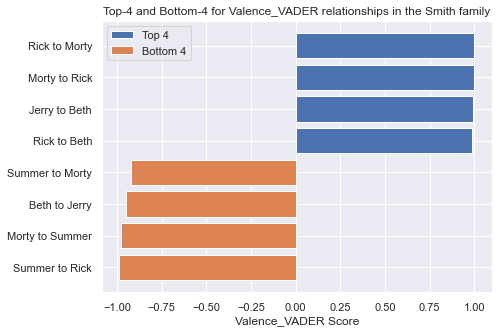

count      mean       std     min     25%     50%     75%  \
Valence_VADER   19.0  0.346626  0.868709 -0.9865 -0.7468  0.7996  0.9813   

                  max  
Valence_VADER  0.9999

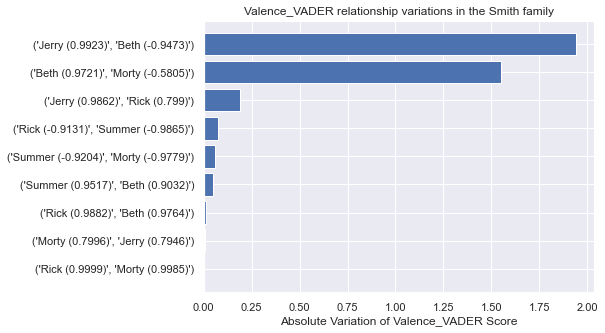

In [76]:
sentiment = 'Valence_VADER'
plot_top5_bottom5(sentiment, 4)
display(get_stats(sentiment))
plot_interactions_comparison(sentiment)

In [77]:
analyse_interactions_NRC('Morty','Summer')['VAD scores']

{'Valence': 0.5568863636363637,
 'Dominance': 0.49376515151515143,
 'Arousal': 0.4557045454545454}

In [78]:
analyse_interactions_NRC('Summer','Morty')['VAD scores']

{'Dominance': 0.5106428571428572,
 'Valence': 0.5019571428571428,
 'Arousal': 0.4944571428571427}

In [79]:
analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon = all_lexicons['Arousal']
print(analyzer.polarity_scores(get_text_of('Summer','Morty')))
print(analyzer.polarity_scores(get_text_of('Morty','Summer')))

{'neg': 0.249, 'neu': 0.525, 'pos': 0.226, 'compound': 0.7506}
{'neg': 0.418, 'neu': 0.392, 'pos': 0.19, 'compound': -0.9996}


In [80]:
get_text_of('Morty','Beth')

"I wasn't kissing a pillow, mom. I just I didn't get a lot of sleep last night. Maybe my dreams were just too loud or something. Dad, mom, come on. Rick just needed my help is all. I know how to vacuum Mom and Dad, Summer, I've been doing it for six months! I’m going to go find Mom and Dad. He bails on everybody! He bailed on Mom when she was a kid! He -- He bailed on tiny planet! And in case I never made this clear to you, Summer, he bailed on you. He left you to rot in a world that he ruined because he doesn't care! Because nobody's special to him, Summer, not even himself. So, if you really want your grandpa back, grab a shovel. The one that won't let you down is buried in your backyard! I think... no matter what we put on there, we die. he said it's the part of the Vindicators he values. That means nothing. He wants our last moment alive to be spent knowing how few fucks he gave. Everyone in the universe is a hero, Mom. Which is why we don't need jackets.  And I'm pretty sure we do

**For each character individually : irrelevant**

In [83]:
df_family_individual_sentiment_scores = pd.read_csv('family_individual_sentiment_scores.csv')

In [84]:
# Other metrics
interactions_other_scores = []

for aSourceChar in family_list.keys():
    for aTargetChar in family_list.keys():
        results_perso = analyse_one_char_words(aSourceChar)
        nb_tokens_total = len(results_perso['tokens'])
        if aSourceChar != aTargetChar:
            results = analyse_interactions_NRC(aSourceChar,aTargetChar)
            nb_tokens = len(results['tokens'])
            if nb_tokens > 100 :
                nb_interrogations = results['lines'].count('?')
                nb_exclamations = results['lines'].count('!')
                nb_egocentric = results['lines'].lower().count('i')+results['lines'].lower().count('me')+results['lines'].lower().count('my')
                nb_you = results['lines'].lower().count('you')
                aRow = [aSourceChar, aTargetChar, nb_tokens, nb_tokens/nb_tokens_total, nb_interrogations/nb_tokens, nb_exclamations/nb_tokens, nb_egocentric/nb_tokens, nb_you/nb_tokens]
                interactions_other_scores.append(aRow)

# to dataframe
df_interactions_other_scores = pd.DataFrame(interactions_other_scores,columns=['Source','Target','Nb_tokens','Ratio', 'Interrogation','Exclamation','Egocentric','You'])

In [85]:
df_interactions_other_scores.sort_values('Egocentric',ascending=False)

Source  Target  Nb_tokens     Ratio  Interrogation  Exclamation  \
18  Summer   Jerry        286  0.077193       0.013986     0.055944   
14   Jerry    Beth        473  0.079031       0.016913     0.023256   
4    Morty    Rick       4298  0.382520       0.033737     0.039321   
12   Jerry    Rick        473  0.079031       0.029598     0.016913   
7    Morty  Summer        619  0.055091       0.012924     0.035541   
5    Morty    Beth        297  0.026433       0.013468     0.043771   
8     Beth    Rick        482  0.128946       0.033195     0.018672   
11    Beth  Summer        175  0.046816       0.017143     0.022857   
3     Rick  Summer        627  0.026169       0.007974     0.030303   
15  Summer    Rick        440  0.118758       0.031818     0.034091   
9     Beth   Morty        276  0.073836       0.032609     0.003623   
2     Rick   Jerry       1303  0.054382       0.024559     0.013047   
6    Morty   Jerry        516  0.045924       0.038760     0.040698   
10    Beth   Jerry        674  0.180310       0.020772     0.014837   
0     Rick   Morty      10607  0.442696       0.015273     0.019798   
16  Summer   Morty        259  0.069906       0.011583     0.050193   
13   Jerry   Morty        347  0.057978       0.008646     0.023055   
17  Summer    Beth        128  0.034548       0.023438     0.093750   
1     Rick    Beth        670  0.027963       0.017910     0.005970   

    Egocentric       You  
18    0.349650  0.027972  
14    0.334038  0.042283  
4     0.333876  0.047697  
12    0.321353  0.061311  
7     0.319871  0.051696  
5     0.319865  0.033670  
8     0.319502  0.047718  
11    0.314286  0.051429  
3     0.314195  0.036683  
15    0.304545  0.047727  
9     0.304348  0.050725  
2     0.297774  0.055257  
6     0.294574  0.048450  
10    0.286350  0.051929  
0     0.281512  0.044405  
16    0.277992  0.050193  
13    0.273775  0.057637  
17    0.273438  0.078125  
1     0.255224  0.040299

In [86]:
sentiment_focus = 'Dominance'
df_NRC_VAD[df_NRC_VAD.Word.isin(results['tokens'])].sort_values(sentiment_focus, ascending=False)[['Word',sentiment_focus]]

Word  Dominance
7589        god      0.886
4082    creator      0.856
3452   complete      0.809
6743      first      0.788
4325        dad      0.786
...         ...        ...
10839       may      0.245
16473     sorry      0.212
11644      need      0.200
10434      lose      0.176
16024     silly      0.161

[80 rows x 2 columns]

<a id='3.6.'></a>
## 3.6.  Study Beth and Jerry marriage through seasons

In [87]:
def add_line_to_season(aRow):
    seasons_strings[aRow['season no.']] += aRow['line']

seasons_strings = {k:'' for k in range (1,6)}

for aSeason in range(1,6):
    df_season = df_transcripts[df_transcripts['season no.']==aSeason]
    _ = df_season.apply(add_line_to_season, axis=1)

In [88]:
# create NLTK objects: Corpus and Text
corpus_root = 'transcripts/per_season'
all_files = [f for f in listdir(corpus_root) if isfile(join(corpus_root, f))]
seasonCorpus = PlaintextCorpusReader(corpus_root, all_files)
seasonText = nltk.Text(seasonCorpus.words())

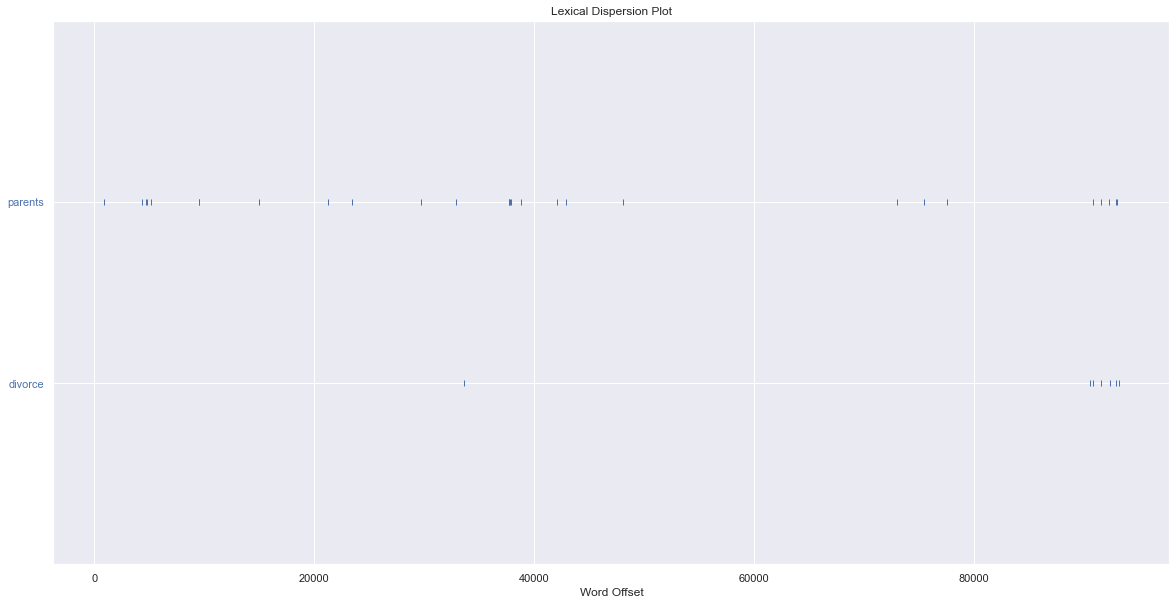

In [89]:
seasonText.dispersion_plot(["parents","divorce"])

In [90]:
seasonText.concordance('divorce')

Displaying 7 of 7 matches:
know , it has been lonely since the divorce . Some voids can ’ t be filled with
You know , I mean , I - I think the divorce is affecting her . And , you know ,
n , her parents are going through a divorce . Damn it , Rick , that ' s what I 
n properly deal with your parents ' divorce ! Alternatively , I have a freaking
z , I ' m so down with my parents ' divorce , dawg . Like , don ' t even trip ,
h . I got to deal with my parents ' divorce , and you got to , you know , do wh
w . My daughter ' s going through a divorce , and I am not dealing with it in a


In [91]:
seasonText.similar("divorce")

thing family universe rick a crazy guy world living lot hell scalpel
way floor man adventure second process fact system


In [92]:
# get one document per season
season_documents = {aSeason:nltk.Text(seasonCorpus.words(['S0'+str(aSeason)+'.txt'])) for aSeason in seasons_strings.keys()}
season_documents

{1: <Text: Morty ! You gotta come on . Jus...>,
 2: <Text: Hurry up Morty , Grampa ' s about...>,
 3: <Text: Anyway , that ' s how I escaped...>,
 4: <Text: ...>,
 5: <Text: It ’ s the crowmad ! Give it...>}

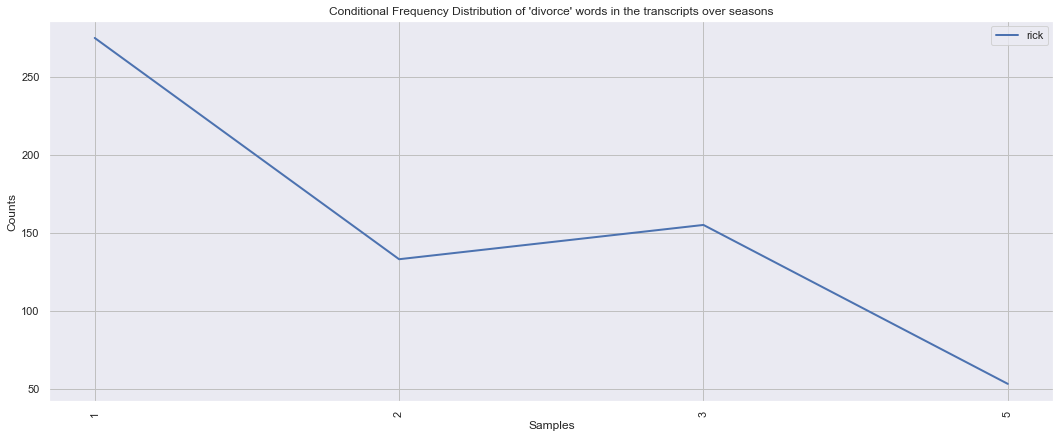

In [93]:
cfd_seasons = nltk.ConditionalFreqDist(
    (target, aSeason) 
    for aSeason in range(1,6)
    for w in seasonCorpus.words(['S0'+str(aSeason)+'.txt'])
    for target in ['rick']
    if w.lower().startswith(target)
)

plt.figure(figsize=(18,7))
plt.title("Conditional Frequency Distribution of 'divorce' words in the transcripts over seasons")
_ = cfd_seasons.plot()

<a id='3.7.'></a>
## 3.7.  Sentiment Analysis: Characters

For the rest sentiment analysis that we did, we decided to divide for each word the sentiments to either positive or negative, which are more general and set the rest as emotions which are more specific.

The dataframe below shows how the lexicon was initially. There are some words that are related to more that one sentiment. Most of them are characterised as positive or negative, among with any other sentiment or no other sentiment at all.

We divided the sentiments as:
* generally positive: positive, joy, trust, anticipation, surprise
* or generally negative: negative, sadness, anger, disgust, fear

We also used the other emotions, if existing, for each word, for more detailed analysis.

In [139]:
df_nrc.head(20)

word sentiment
0        abacus     trust
1       abandon      fear
2       abandon  negative
3       abandon   sadness
4     abandoned     anger
5     abandoned      fear
6     abandoned  negative
7     abandoned   sadness
8   abandonment     anger
9   abandonment      fear
10  abandonment  negative
11  abandonment   sadness
12  abandonment  surprise
13         abba  positive
14        abbot     trust
15    abduction      fear
16    abduction  negative
17    abduction   sadness
18    abduction  surprise
19     aberrant  negative

In [94]:
# Replacing the names of some characters at df_transcripts to match the names in df_characters
df_transcripts["name"].replace({"Rick": "Rick Sanchez"}, inplace=True)
df_transcripts["name"].replace({"Evil Rick": "Evil Rick Sanchez"}, inplace=True)
df_transcripts["name"].replace({"Pickle Rick": "Pickle Rick (character)"}, inplace=True)
df_transcripts["name"].replace({"Morty": "Morty Smith"}, inplace=True)
df_transcripts["name"].replace({"Beth": "Beth Smith"}, inplace=True)
df_transcripts["name"].replace({"Jerry": "Jerry Smith"}, inplace=True)
df_transcripts["name"].replace({"Summer": "Summer Smith"}, inplace=True)
df_transcripts["name"].replace({"'Rick D716-B": "Rick D716-B"}, inplace=True)

In [95]:
# A dataframe with all the lines of each character
df_charLines = df_transcripts.groupby(['name'], as_index = False).agg({'line': ' '.join})
#Remove stopwords
df_charLines.line = df_charLines.line.apply(lambda x: remove_stopwords(x))
df_charLines

In [96]:
# A dictionary with all the lines of each character
characters_dialogue = df_charLines.set_index('name').T.to_dict('records')[0]
characters_dialogue

In [97]:
def get_list_of_tokens(aSentence):
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens



def get_nrc_sentiment(aWord):
    # Match the word with the relevant sentiments 
    if (aWord in list(df_nrc.word)):
        sentiment = list(df_nrc.sentiment[df_nrc.word == aWord])
    else:    
        sentiment = []
    return sentiment    

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_nrc_sentiments(aListOfTokens):
    # Combine in a dict the amount of words associated  with each sentiment for a list of tokens
    sentiment_list = []
    sentiment_dict = {'positive': 0, 'negative': 0, 'trust': 0, 'anticipation': 0, 'fear': 0, 'joy': 0, 'anger': 0, 'disgust': 0, 'sadness': 0, 'surprise': 0}
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            sentiment = get_nrc_sentiment(aToken)   
            sentiment_list.extend(sentiment)
        dd = dict(Counter(sentiment_list))
        d =  {k: dd.get(k, 0) + sentiment_dict.get(k, 0) for k in sentiment_dict.keys()}
    else:
        d = sentiment_dict  
    return d

In [98]:
# Calculate the NRC sentiment score for each character

sentiment_NRC_list = []
count_list = []

def calculate_NRC_sentiment_of_a_character(aRow):
    # For each character get the sentiment dictionary and count the number of words he says and exist in NRC lexicon
    if aRow.Name in list(characters_dialogue.keys()):
        sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(characters_dialogue[aRow.Name]))
        
        count = 0
        for word in get_list_of_tokens(characters_dialogue[aRow.Name]):
            if (word in list(df_nrc.word)):
                count+=1
        
        
        sentiment_NRC_list.append(sentiment_NRC) 
        count_list.append(count)
        
    else:
        sentiment_NRC_list.append(None)
        count_list.append(None)


# Apply to the whole dataframe
_ = df_characters.apply(calculate_NRC_sentiment_of_a_character, axis=1)

# Store in dataframe of characters as new columns
df_characters['NRC_score'] = sentiment_NRC_list
df_characters['NRC_words'] = count_list
# Create a new dataframe to use for the analysis with the characters for whom we have results 
df_NRC = df_characters[df_characters.NRC_score.notnull()]   # df_NRC.count() = 80
df_NRC = df_NRC[df_NRC.NRC_words != 0]   # df_NRC.count() = 73
df_NRC.head()

In [99]:
NRC_emotions_list = []
positive_list = []
negative_list = []
positive_portion_list = []
negative_portion_list = []
NRC_emotions_portion_list = [] 


def calculate_NRC_portions_of_a_character(aRow):
    # Separate for each charatcer the dictionaries into positive score (int), negative score (int) and the rest emotions 
    
    dictChar = df_NRC[df_NRC.Name == aRow.Name]['NRC_score'].values[0]
    # Determine the positive and negative scores (adding accordinlgy the rest emotions in each one)
    positive = dictChar['positive'] + dictChar['trust'] + dictChar['anticipation'] + dictChar['joy'] + dictChar['surprise']
    negative = dictChar['negative'] + dictChar['fear'] + dictChar['anger'] + dictChar['disgust'] + dictChar['sadness']
    # Remove positive and negative from the rest emotions
    keys = list(dictChar.keys())
    keys.remove('positive')
    keys.remove('negative')
    emotions_dict  =  { k: dictChar[k] for k in keys}
    
    count = df_NRC[df_NRC.Name == aRow.Name]['NRC_words'].values[0]
    
    # Find the percentages        
    emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
    positive_portion = positive / (positive + negative) * 100
    negative_portion = negative / (positive + negative) * 100
    
    
    NRC_emotions_list.append(emotions_dict)
    NRC_emotions_portion_list.append(emotions_portion_dict)
    positive_list.append(positive)
    negative_list.append(negative)
    positive_portion_list.append(positive_portion)
    negative_portion_list.append(negative_portion)
    


# Apply to the whole dataframe    
_ = df_NRC.apply(calculate_NRC_portions_of_a_character, axis=1)

# Store in dataframe of NRC characters as new columns
df_NRC['Positive'] = positive_list
df_NRC['Positive_portion'] = positive_portion_list
df_NRC['Negative'] = negative_list
df_NRC['Negative_portion'] = negative_portion_list
df_NRC['Emotions'] = NRC_emotions_list
df_NRC['Emotions_portion'] = NRC_emotions_portion_list
df_NRC.head()

In [100]:
# Function to sort the dictionaries
def sort_dict(d):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = True)}

In [101]:
# Plot for each character's sentiments
   
def piechart_characters_sentiments(name):
    
    labels = 'Positive', 'Negative'
    sizes = [df_NRC[df_NRC.Name == name]['Positive'].values[0], df_NRC[df_NRC.Name == name]['Negative'].values[0]]
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
    ax.axis('equal')  
    ax.set_title(name + ': Sentiments')
    

# Plot for each character's emotions  
    
def plot_seaborn_character_emotions(name):
  
    d = df_NRC[df_NRC.Name == name]['Emotions_portion'].tolist()[0]
    d = sort_dict(d)
    f, ax = plt.subplots() 
    y = list(d.keys())
    x = list(d.values())  # weight 
    sns.set(rc = {'figure.figsize':(5,5)})
    sns.barplot(x=x, y=y, palette="deep", ax=ax) 
    ax.set_xlabel('Percentage (%)')
    ax.invert_yaxis()  # labels read top-to-bottom
    count_words = df_NRC[df_NRC.Name == name]['NRC_words'].values[0]
    ax.set_title(name + ': Emotions')
    #ax.set_title(name + ': Emotions  (' + str(count_words) + ' NRC words)')
    ax.set_xlim([0, 50])
    ax.invert_yaxis() 


(None,)

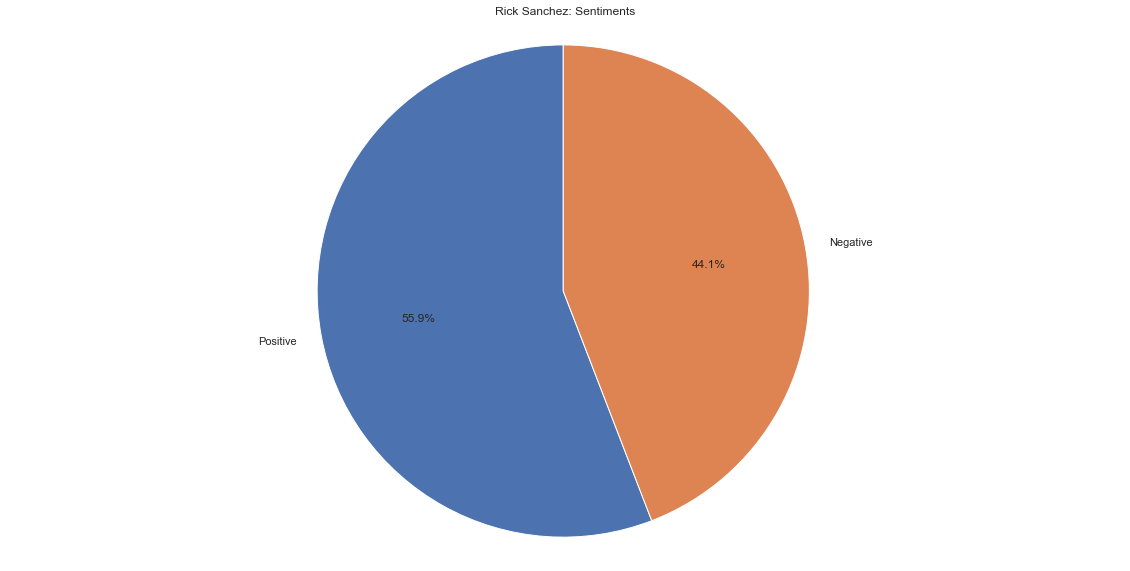

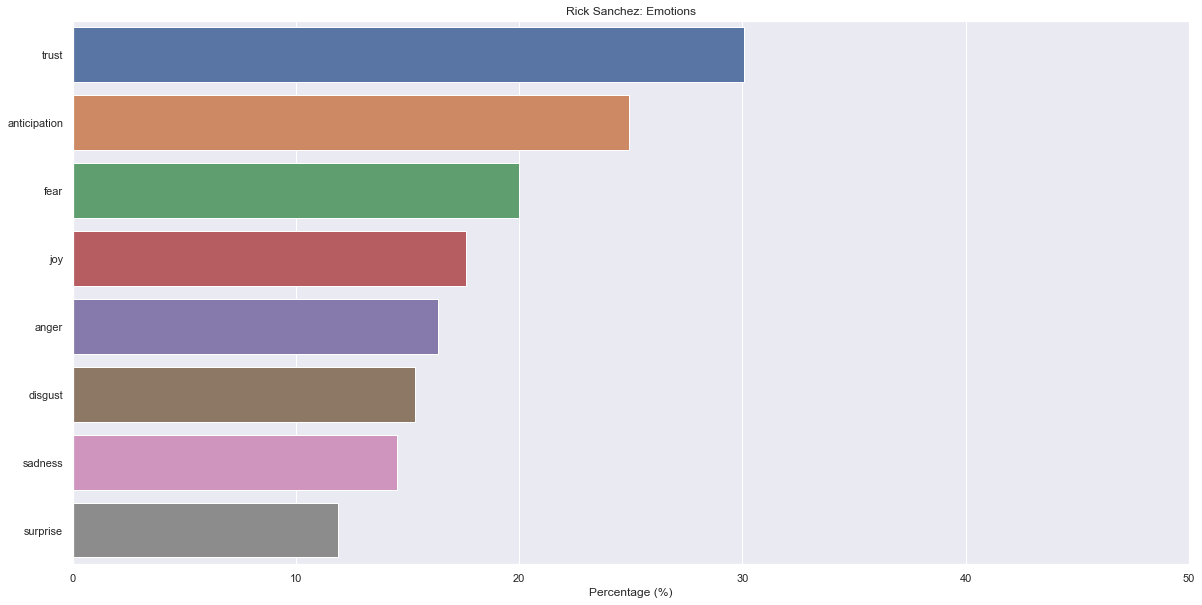

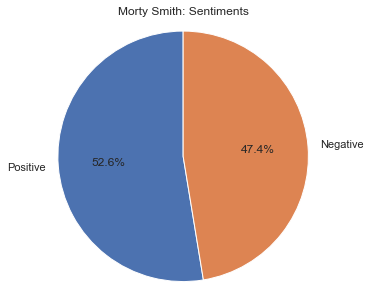

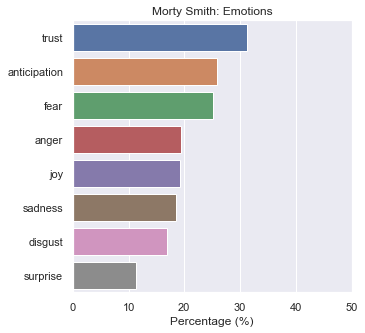

In [102]:
piechart_characters_sentiments('Rick Sanchez'),
plot_seaborn_character_emotions('Rick Sanchez')
piechart_characters_sentiments('Morty Smith'),
plot_seaborn_character_emotions('Morty Smith'),
# piechart_characters_sentiments('Summer Smith'),
# plot_seaborn_character_emotions('Summer Smith'),
# piechart_characters_sentiments('Beth Smith'),
# plot_seaborn_character_emotions('Beth Smith')
# piechart_characters_sentiments('Jerry Smith'),
# plot_seaborn_character_emotions('Jerry Smith')

**Top characters for each sentiment**

In [103]:
# Filtering df_NRC to keep only those with more than 50 nrc words
df_NRC_filtered = df_NRC[df_NRC.NRC_words > 50]

sent_dict = {}

def a_sentiment_for_a_character(aRow, sentiment):
    if sentiment == 'positive':
        sent_dict[aRow.Name] = round(aRow.Positive_portion,2)
    elif sentiment == 'negative':    
        sent_dict[aRow.Name] = round(aRow.Negative_portion, 2)
    else:    
        sent_dict[aRow.Name] = round(aRow.Emotions_portion[sentiment], 2)

def top_characters_for_a_sentiment(sentiment):
    _ = df_NRC_filtered.apply(lambda x: a_sentiment_for_a_character(x, sentiment), axis=1)     


In [104]:

def print_top_10(sentiment):
    top_characters_for_a_sentiment(sentiment)
    d = sort_dict(sent_dict)
    d1 = dict(list(d.items())[:10])

    i=1
    for k, v in d1.items():
        print("{}. {} ({}%)".format(i, k, v))
        i+=1

In [105]:
sentiments = {'positive', 'negative', 'trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise'}
for sent in sentiments:
    print(sent+':\n')
    print_top_10(sent)
    print('\n')

disgust:

1. Toxic Rick (38.82%)
2. Morty Smith (16.9%)
3. Summer Smith (16.28%)
4. Rick Sanchez (15.32%)
5. Unity (15.07%)
6. Dr. Wong (15.0%)
7. Jerry Smith (13.03%)
8. Pickle Rick (character) (12.9%)
9. Mr. Goldenfold (12.73%)
10. Beth Smith (11.03%)


trust:

1. Principal Vagina (61.11%)
2. Mr. Goldenfold (45.45%)
3. Summer Smith (38.6%)
4. Beth Smith (36.41%)
5. Unity (32.88%)
6. Jerry Smith (32.15%)
7. Morty Smith (31.32%)
8. Rick Sanchez (30.06%)
9. Dr. Wong (26.67%)
10. Pickle Rick (character) (25.0%)


anger:

1. Toxic Rick (20.0%)
2. Morty Smith (19.47%)
3. Dr. Wong (16.67%)
4. Rick Sanchez (16.38%)
5. Mr. Goldenfold (16.36%)
6. Summer Smith (15.12%)
7. Unity (15.07%)
8. Jerry Smith (14.72%)
9. Pickle Rick (character) (12.1%)
10. Beth Smith (11.54%)


fear:

1. Dr. Wong (36.67%)
2. Unity (32.88%)
3. Summer Smith (27.67%)
4. Morty Smith (25.2%)
5. Pickle Rick (character) (21.77%)
6. Toxic Rick (21.18%)
7. Beth Smith (20.26%)
8. Rick Sanchez (19.98%)
9. Mr. Goldenfold (16.36%)


**Histograms for all characters' sentiments**

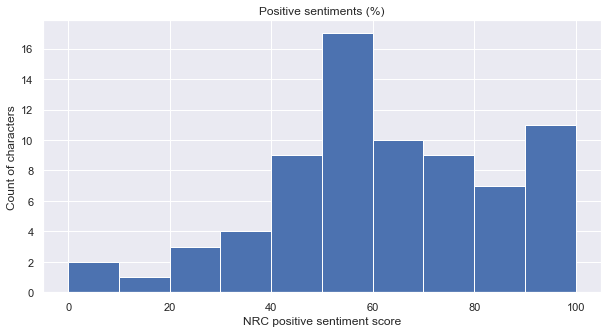

In [106]:
plt.figure(figsize=(10,5))
plt.hist(df_NRC.Positive_portion)
plt.title("Positive sentiments (%)")
plt.xlabel("NRC positive sentiment score")
plt.ylabel("Count of characters")
plt.show()

**Comparison of different characters' sentiments**

In [107]:
# Divide the plots into two different. The general one (positive, negative) and the more detaled one (emotions)

def grouped_bar_chart_for_characters_sentiments(characters_list):


    characters = []
    sentiments = []
    score = []
    
    for c in characters_list:
        
        positive = df_NRC[df_NRC.Name == c ].Positive_portion.tolist()[0]
        characters.append(c)
        sentiments.append('Positive')
        score.append(positive)
        
        negative = df_NRC[df_NRC.Name == c ].Negative_portion.tolist()[0]
        characters.append(c)
        sentiments.append('Negative')
        score.append(negative)


    # Assign data of lists  
    data = {'Name': characters, 'Sentiment': sentiments, 'Score': score}  

    # Create DataFrame for plotting 
    df_chars_sentiments = pd.DataFrame(data)     
    
    sns.set(rc = {'figure.figsize':(20,15)})
    g = sns.catplot(
        data=df_chars_sentiments, kind="bar",
        x="Name", y="Score", hue="Sentiment",
        ci="sd", palette="dark", alpha=.6, height=5, aspect=10/5
    )
    g.despine(left=True)
    g.set_axis_labels("", "Weight (%)")
    g.legend.set_title("Sentiments")
    

def grouped_bar_chart_for_characters_emotions(characters_list):

    keys = []
    values = []
    characters = []

    for c in characters_list:
        d = df_NRC[df_NRC.Name == c ].Emotions_portion.tolist()[0]

        for item in d.items():
            characters.append(c), keys.append(item[0]), values.append(item[1])

    # Assign data of lists 
    data = {'Name': characters, 'Emotion': keys, 'Score': values}  

    # Create DataFrame for plotting 
    df_chars_emotions = pd.DataFrame(data)     
    sns.set(rc = {'figure.figsize':(20,15)})
    g = sns.catplot(
        data=df_chars_emotions, kind="bar",
        x="Name", y="Score", hue="Emotion",
        ci="sd", palette="dark", alpha=.6, height=5, aspect=11.7/5
    )
    g.despine(left=True)
    g.set_axis_labels("", "Weight (%)")
    g.legend.set_title("Emotions")


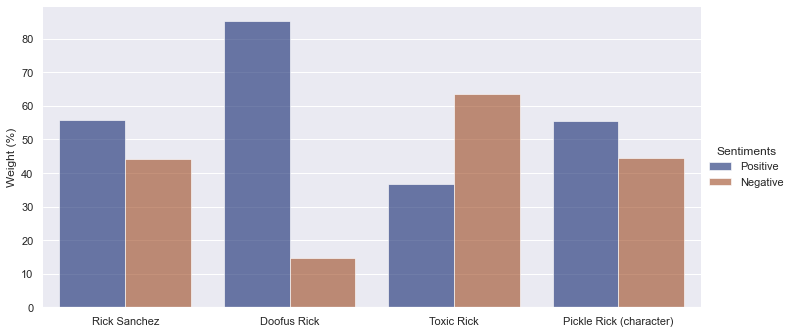

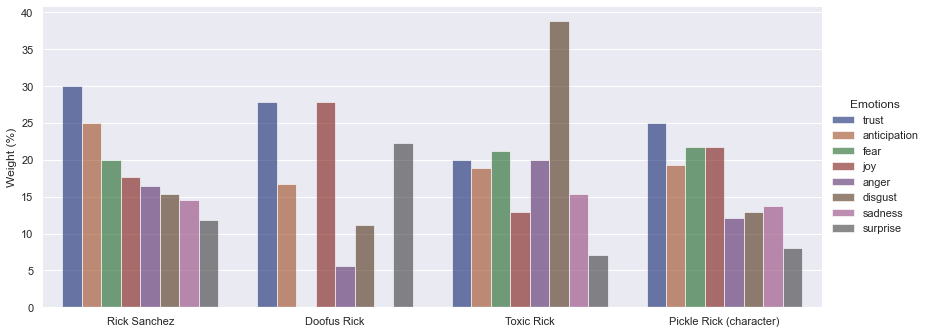

In [108]:
Ricks = ['Rick Sanchez', 'Doofus Rick', 'Toxic Rick', 'Pickle Rick (character)']
grouped_bar_chart_for_characters_sentiments(Ricks),
grouped_bar_chart_for_characters_emotions(Ricks)

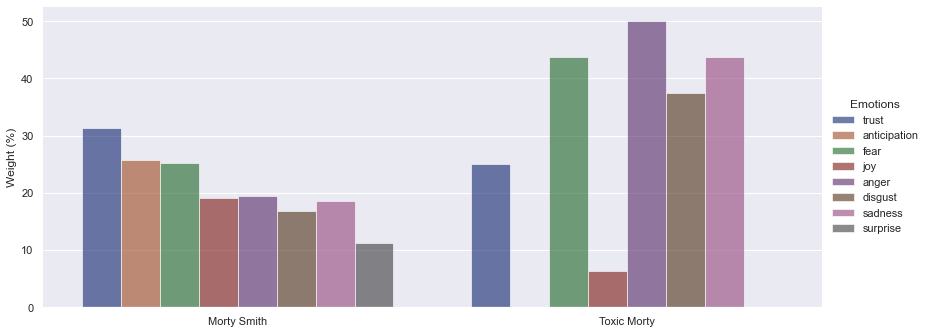

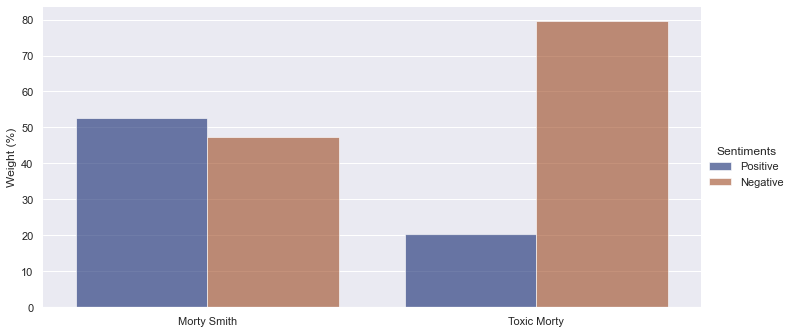

In [109]:
Mortys = ['Morty Smith', 'Toxic Morty']

grouped_bar_chart_for_characters_emotions(Mortys),
grouped_bar_chart_for_characters_sentiments(Mortys)

<a id='3.8.'></a>
## 3.8.  Sentiment Analysis: Episode

In [110]:
# A dataframe with all the lines of each episode
df_episode_lines = df_transcripts.groupby(['season no.', 'episode no.', 'episode name'], as_index = False).agg({'line': ' '.join})
# Remove stopwords
df_episode_lines.line = df_episode_lines.line.apply(lambda x: remove_stopwords(x))
df_episode_lines

In [ ]:
# A dictionary with all the lines of each episode
episodes_dialogue = df_episode_lines.set_index(['season no.', 'episode no.', 'episode name']).T.to_dict('records')[0]
episodes_dialogue

In [111]:
def get_list_of_tokens(aSentence):
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens



def get_nrc_sentiment(aWord):
    # Match the word with the relevant sentiments 
    if (aWord in list(df_nrc.word)):
        sentiment = list(df_nrc.sentiment[df_nrc.word == aWord])
    else:    
        sentiment = []
    return sentiment    

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_nrc_sentiments(aListOfTokens):
    # # Combine in a dict the amount of words associated  with each sentiment for a list of tokens
    sentiment_list = []
    sentiment_dict = {'positive': 0, 'negative': 0, 'trust': 0, 'anticipation': 0, 'fear': 0, 'joy': 0, 'anger': 0, 'disgust': 0, 'sadness': 0, 'surprise': 0}
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            sentiment = get_nrc_sentiment(aToken)   
            sentiment_list.extend(sentiment)
        dd = dict(Counter(sentiment_list))
        d =  {k: dd.get(k, 0) + sentiment_dict.get(k, 0) for k in sentiment_dict.keys()}
    else:
        d = sentiment_dict  
    return d

In [112]:
# Calculate the NRC sentiment score for each episode

sentiment_NRC_list = []
count_list = []

def calculate_NRC_sentiment_of_an_episode(aRow):
    # For each episode get the sentiment dictionary and count the number of words said and exist in NRC lexicon
    if (aRow['season no.'], aRow['episode no.'], aRow['episode name']) in list(episodes_dialogue.keys()):
        sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(episodes_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]))
        
        count = 0
        for word in get_list_of_tokens(episodes_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]):
            if (word in list(df_nrc.word)):
                count+=1
        
        
        sentiment_NRC_list.append(sentiment_NRC) 
        count_list.append(count)
        
    else:
        sentiment_NRC_list.append(None)
        count_list.append(None)


# Apply to the whole dataframe
_ = df_episode_lines.apply(calculate_NRC_sentiment_of_an_episode, axis=1)


# Store in dataframe of episodes as a new column
df_episode_lines['NRC_score'] = sentiment_NRC_list
df_episode_lines['NRC_words'] = count_list
# Create a new dataframe  with the episodes for the rest analysis
df_NRC_episodes = df_episode_lines[df_episode_lines.NRC_score.notnull()]
df_NRC_episodes = df_NRC_episodes[df_NRC_episodes.NRC_words != 0]
df_NRC_episodes.head()

In [113]:
NRC_emotions_list = []
positive_list = []
negative_list = []
positive_portion_list = []
negative_portion_list = []
NRC_emotions_portion_list = [] 


def calculate_NRC_portions_of_an_episode(aRow):
    # Separate for each charatcer the dictionaries into positive score (int), negative score (int) and the rest emotions    
    dictEp = df_NRC_episodes[df_NRC_episodes['episode name'] == aRow['episode name']]['NRC_score'].values[0]
    
    # Determine the positive and negative scores (adding accordinlgy the rest emotions in each one)
    positive = dictEp['positive'] + dictEp['trust'] + dictEp['anticipation'] + dictEp['joy'] + dictEp['surprise']
    negative = dictEp['negative'] + dictEp['fear'] + dictEp['anger'] + dictEp['disgust'] + dictEp['sadness']
    # Remove positive and negative from the rest emotions
    keys = list(dictEp.keys())
    keys.remove('positive')
    keys.remove('negative')
    emotions_dict  =  { k: dictEp[k] for k in keys}
    
    count = df_NRC_episodes[df_NRC_episodes['episode name'] == aRow['episode name']]['NRC_words'].values[0]
    # Find the percentages        
    emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
    positive_portion = positive / (positive + negative) * 100
    negative_portion = negative / (positive + negative) * 100
    
    
    NRC_emotions_list.append(emotions_dict)
    NRC_emotions_portion_list.append(emotions_portion_dict)
    positive_list.append(positive)
    negative_list.append(negative)
    positive_portion_list.append(positive_portion)
    negative_portion_list.append(negative_portion)
    


# Apply to the whole dataframe    
_ = df_NRC_episodes.apply(calculate_NRC_portions_of_an_episode, axis=1)

# Store in dataframe of characters as a new column
df_NRC_episodes['Positive'] = positive_list
df_NRC_episodes['Positive_portion'] = positive_portion_list
df_NRC_episodes['Negative'] = negative_list
df_NRC_episodes['Negative_portion'] = negative_portion_list
df_NRC_episodes['Emotions'] = NRC_emotions_list
df_NRC_episodes['Emotions_portion'] = NRC_emotions_portion_list
df_NRC_episodes.head()

In [114]:
# Plot for sentiments in an episode
   
def piechart_episode_sentiments(season, episode):
    
    labels = 'Positive', 'Negative'
    positive = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Positive'].values[0]
    negative = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Negative'].values[0]
    sizes = [positive, negative]
    plt.figure(figsize=(10,5))
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
    ax.axis('equal')  
    ax.set_title('Season ' + str(season) + ', Episode ' + str(episode) + ': Sentiments')

# Plot for emotions in an episode   

def plot_seaborn_episode_emotions(season, episode):
  
    d = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Emotions_portion'].tolist()[0]
    d = sort_dict(d)
    f, ax = plt.subplots() 
    y = list(d.keys())
    x = list(d.values())  # weight 
    sns.set(rc = {'figure.figsize':(10,5)})
    sns.barplot(x=x, y=y, palette="deep", ax=ax) 
    ax.set_xlabel('Number of words')
    ax.invert_yaxis()  # labels read top-to-bottom
    name = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['episode name'].tolist()[0]
    ax.set_title('Season ' + str(season) + ', Episode ' + str(episode)+ ', Title = ' + name + ' : Emotions')
    ax.set_xlim([0, 100])
    ax.invert_yaxis() 

      
 



<Figure size 720x360 with 0 Axes>

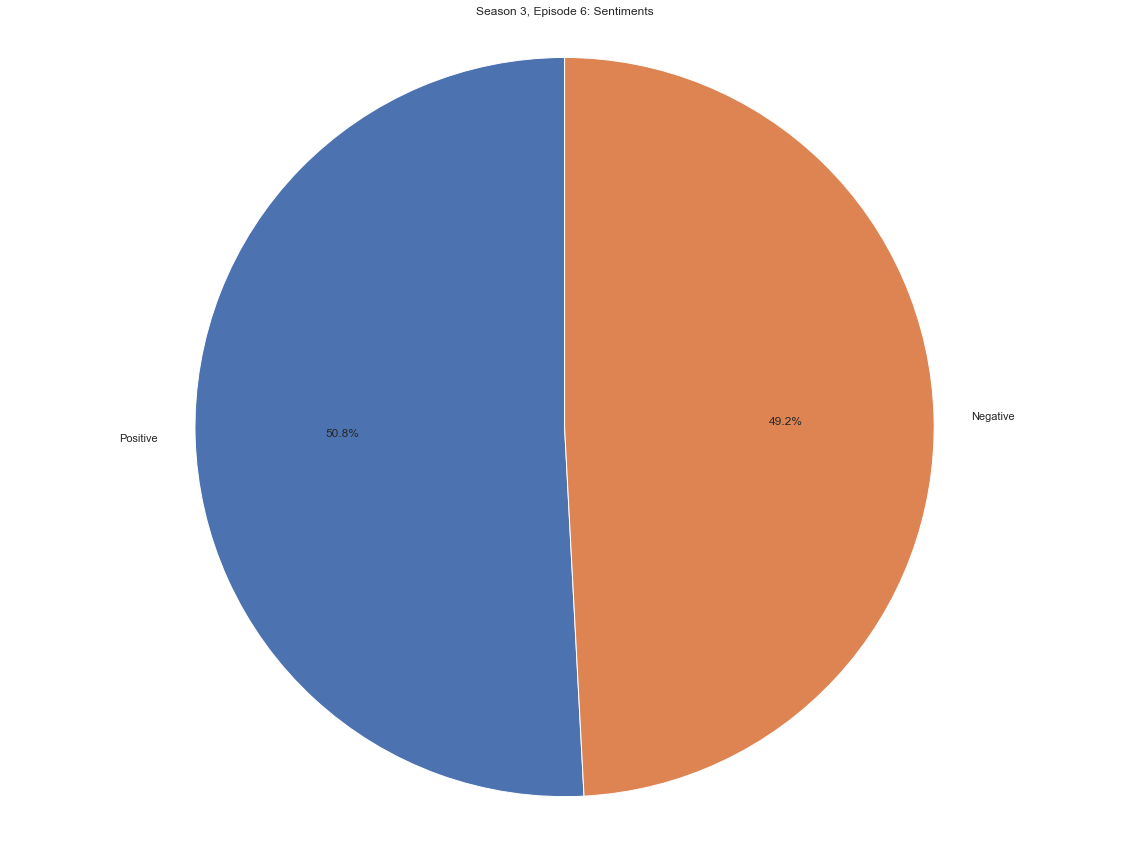

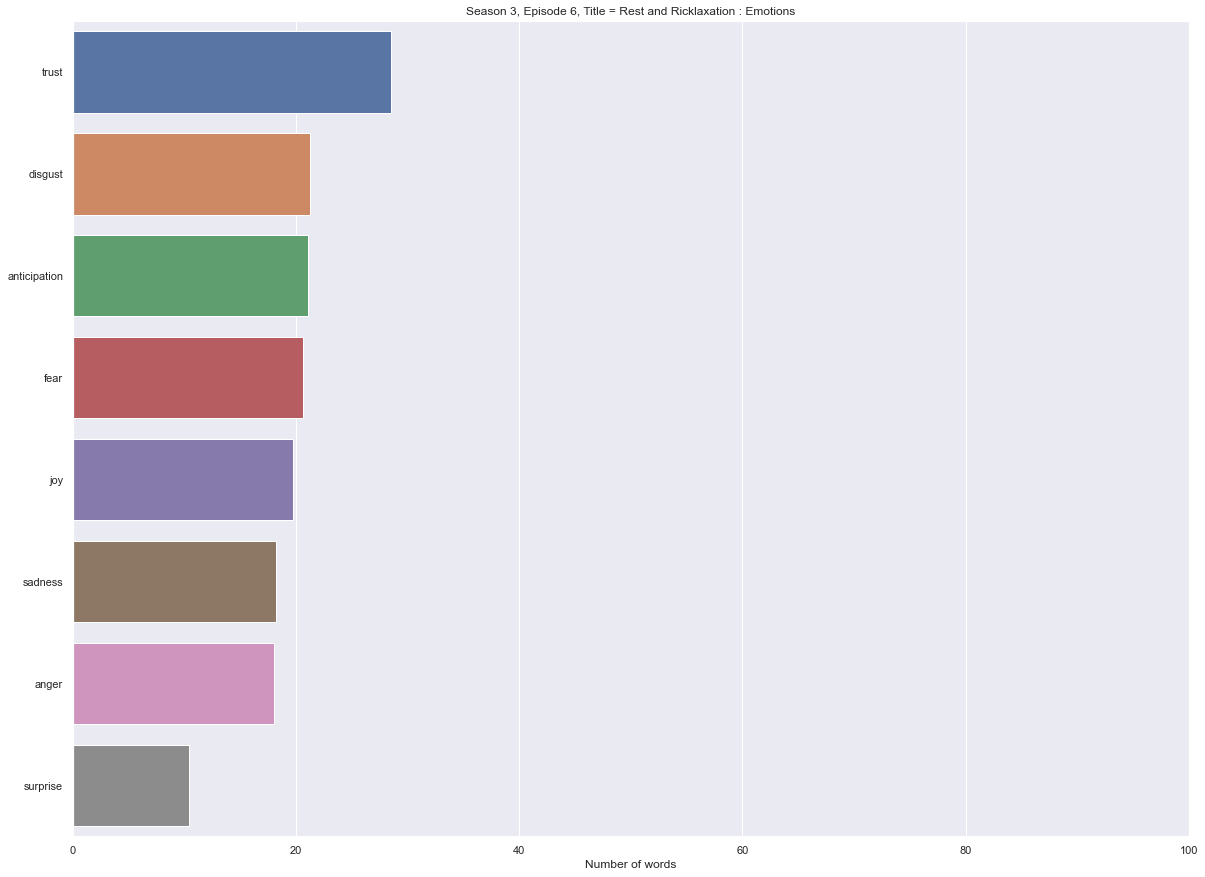

In [115]:
piechart_episode_sentiments(3,6),
plot_seaborn_episode_emotions(3,6)

**Sentiments through seasons**

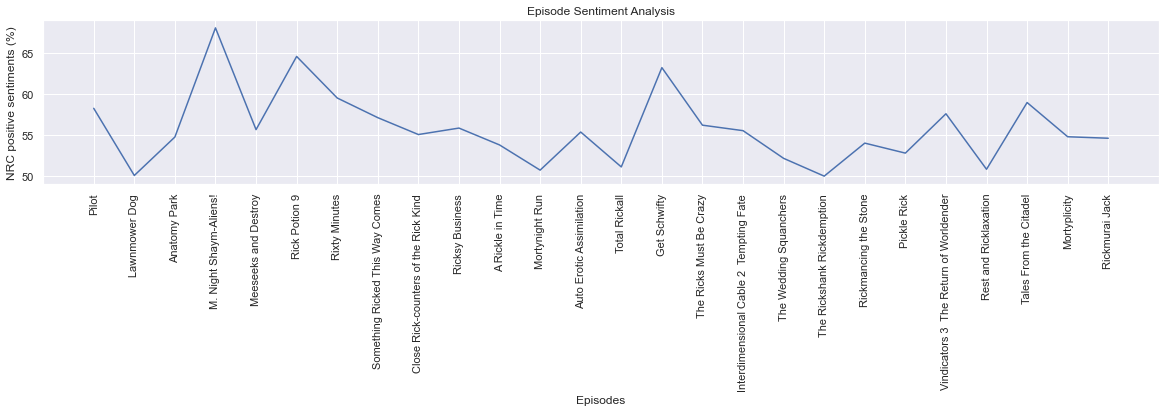

In [116]:
# Plot the sentiments of each episode and display though episodes
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_NRC_episodes['episode name'], df_NRC_episodes.Positive_portion)
plt.xticks(rotation=90)
plt.title("Episode Sentiment Analysis", )
plt.xlabel("Episodes")
plt.ylabel("NRC positive sentiments (%)")
plt.show()

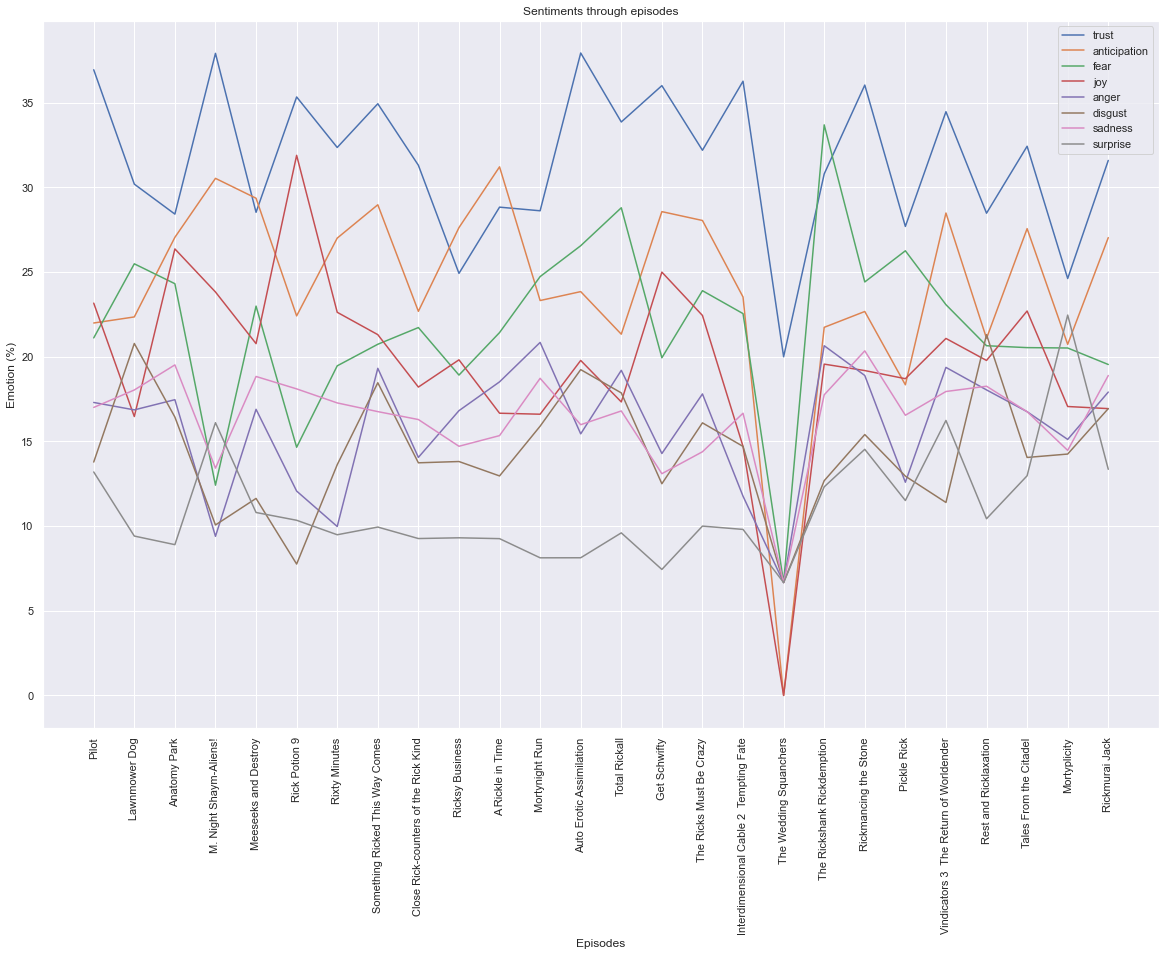

In [117]:
# Plot emotions of each episode
emotions = ['trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise']
plt.rcParams["figure.figsize"] = (20,13)
plt.rcParams["legend.loc"] = 'upper right'
    
for em in emotions:

    episodes = df_NRC_episodes['episode name']
        
    y = []
    for ep in episodes:
        y.append(df_NRC_episodes[df_NRC_episodes['episode name'] == ep].Emotions_portion.values[0][em])
                     
    plt.plot(episodes, y, label = em)
        
        
plt.xticks(rotation=90)
plt.title("Sentiments through episodes")
plt.xlabel("Episodes")
plt.ylabel("Emotion (%)")
plt.legend()
    
plt.show()

<a id='3.9.'></a>
## 3.9.  Sentiment Analysis of Characters Through Episodes

In [118]:
def character_evolvement_NRC(name): 
    
    # A dataframe with the lines of the given character in each episode
    df_char_episode_lines = df_transcripts.groupby(['season no.', 'episode no.', 'episode name', 'name'], as_index = False).agg({'line': ' '.join})
    # Remove stopwords
    df_char_episode_lines.line = df_char_episode_lines.line.apply(lambda x: remove_stopwords(x))
    df_aChar_lines = df_char_episode_lines[df_char_episode_lines.name == name ].drop('name', axis = 1)
    # A dictionary with the lines of each character in each episode
    aChar_dialogue = df_aChar_lines.set_index(['season no.', 'episode no.', 'episode name']).T.to_dict('records')[0]
    sentiment_NRC_list = []
    count_list = []

    
    def calculate_NRC_sentiment_of_a_character_by_episode(aRow):
        # For each episode get the sentiment dictionary and count the number of words the character says and exist in NRC lexicon
        if (aRow['season no.'], aRow['episode no.'], aRow['episode name']) in list(aChar_dialogue.keys()):
            sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(aChar_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]))
            count = 0
            for word in get_list_of_tokens(aChar_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]):
                if (word in list(df_nrc.word)):
                    count+=1


            sentiment_NRC_list.append(sentiment_NRC) 
            count_list.append(count)

        else:
            sentiment_NRC_list.append(None)
            count_list.append(None)

    # Apply to the whole dataframe
    _ = df_aChar_lines.apply(calculate_NRC_sentiment_of_a_character_by_episode, axis=1)



    # Store in dataframe as a new column
    df_aChar_lines['NRC_score'] = sentiment_NRC_list
    df_aChar_lines['NRC_words'] = count_list
    # Create a new dataframe  with the lines of character
    df_NRC_char_through_ep = df_aChar_lines[df_aChar_lines.NRC_score.notnull()]
    df_NRC_char_through_ep = df_NRC_char_through_ep[df_NRC_char_through_ep.NRC_words != 0]
        
        
    NRC_emotions_list = []
    positive_list = []
    negative_list = []
    positive_portion_list = []
    negative_portion_list = []
    NRC_emotions_portion_list = [] 
        
    
    def calculate_NRC_portions_of_a_character_through_episodes(aRow):
        # Separate for each episode the dictionaries into positive score (int), negative score (int) and the rest emotions of character
        dictEp = df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == aRow['episode name']]['NRC_score'].values[0]
        # Determine the positive and negative scores (adding accordinlgy the rest emotions in each one)
        positive = dictEp['positive'] + dictEp['trust'] + dictEp['anticipation'] + dictEp['joy'] + dictEp['surprise']
        negative = dictEp['negative'] + dictEp['fear'] + dictEp['anger'] + dictEp['disgust'] + dictEp['sadness']
        # Remove positive and negative from the rest emotions
        keys = list(dictEp.keys())
        keys.remove('positive')
        keys.remove('negative')
        emotions_dict  =  { k: dictEp[k] for k in keys}

        count = df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == aRow['episode name']]['NRC_words'].values[0]
        # Find the percentages  
        emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
        positive_portion = positive / (positive + negative) * 100
        negative_portion = negative / (positive + negative) * 100


        NRC_emotions_list.append(emotions_dict)
        NRC_emotions_portion_list.append(emotions_portion_dict)
        positive_list.append(positive)
        negative_list.append(negative)
        positive_portion_list.append(positive_portion)
        negative_portion_list.append(negative_portion)



    
    _ = df_NRC_char_through_ep.apply(calculate_NRC_portions_of_a_character_through_episodes, axis=1)

    # Store in dataframe of characters as a new column
    df_NRC_char_through_ep['Positive'] = positive_list
    df_NRC_char_through_ep['Positive_portion'] = positive_portion_list
    df_NRC_char_through_ep['Negative'] = negative_list
    df_NRC_char_through_ep['Negative_portion'] = negative_portion_list
    df_NRC_char_through_ep['Emotions'] = NRC_emotions_list
    df_NRC_char_through_ep['Emotions_portion'] = NRC_emotions_portion_list
    
        

    # Plot sentiments 
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(df_NRC_char_through_ep['episode name'], df_NRC_char_through_ep.Positive_portion)
    plt.xticks(rotation=90)
    plt.title(name + "'s sentiments through episodes")
    plt.xlabel("Episodes")
    plt.ylabel("NRC positive sentiments (%)")
    plt.show()

    
    # Plot emotions
    emotions = ['trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise']
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams["legend.loc"] = 'upper right'
    
    for em in emotions:

        episodes = df_NRC_char_through_ep['episode name']
        
        y = []
        for ep in episodes:
            y.append(df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == ep].Emotions_portion.values[0][em])
                     
        plt.plot(episodes, y, label = em)
        
        
    plt.xticks(rotation=90)
    plt.title(name + "'s sentiments through episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Emotion (%)")
    plt.legend()
    
    plt.show()

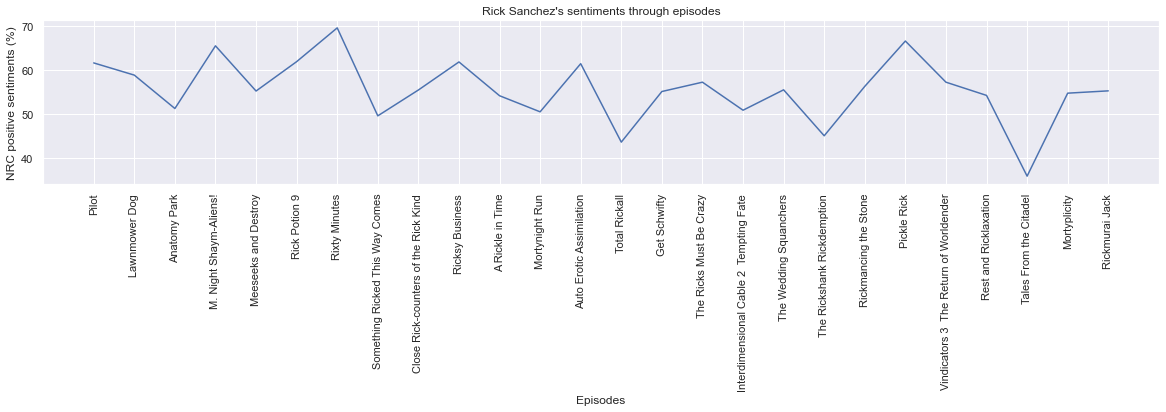

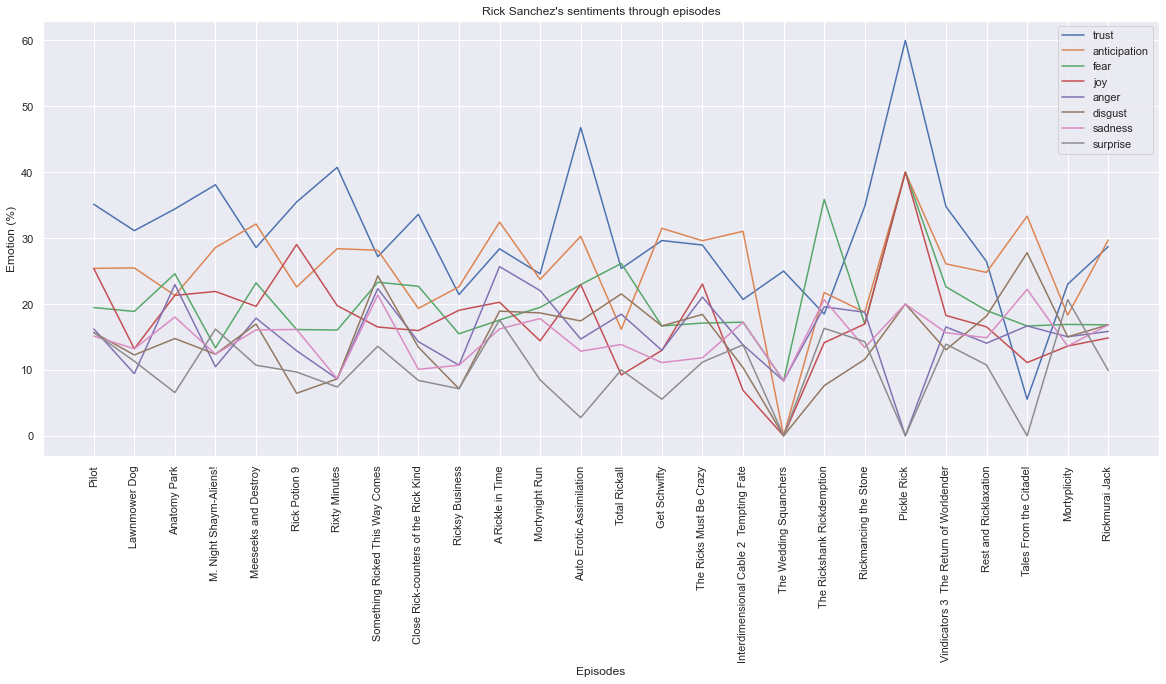

In [119]:
character_evolvement_NRC('Rick Sanchez')

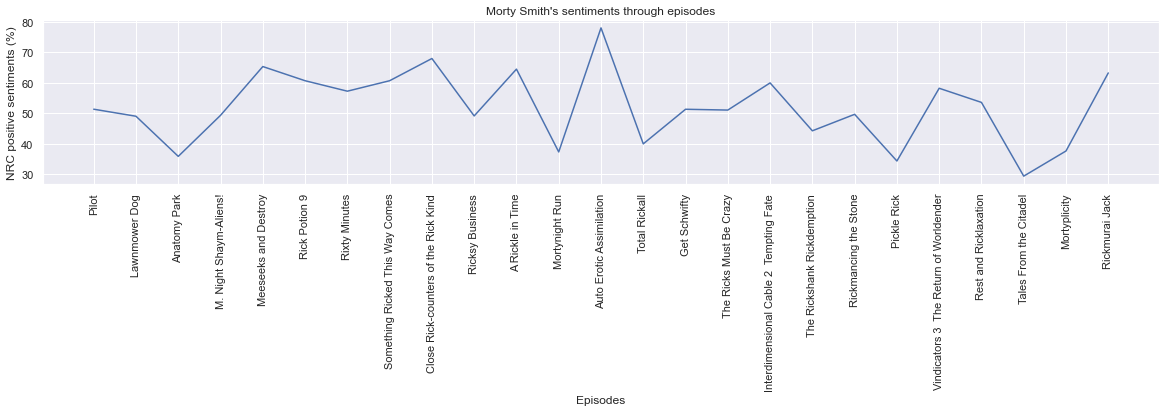

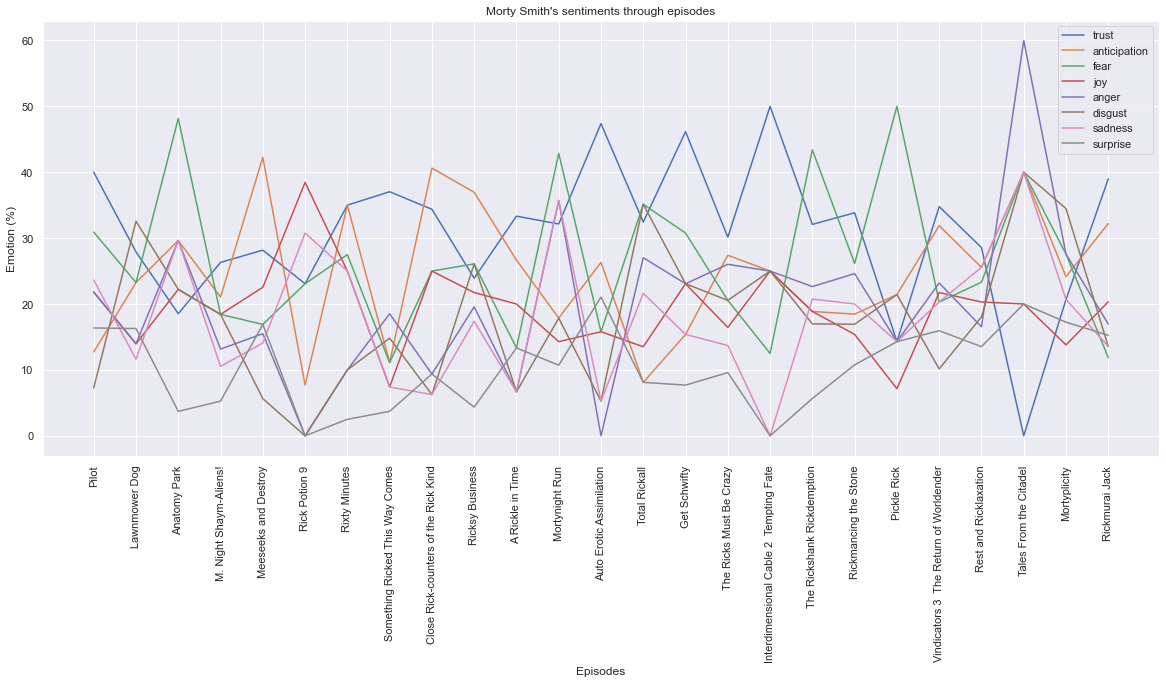

In [120]:
character_evolvement_NRC('Morty Smith')

<a id='4.'></a>
# 4. Discussion

Conclusively, Rick and Morty apart from a great series, is a real nice topic to investigate, since there are several perspectives that can be studied. To be more precise, the network of the series has a good amount of nodes and edges from which you can caclulate statistics, communities and focus on different properties/concept of networks. Moreover the series approach different topics starting from the daily life to disagreements between planets, so it was quite interesting to study the language and how emotions are reflected through it. In general, we tried to apply many of the tools that we learn during the course this semester mainly focusing on 1) communities, since the story of the series takes place in multi-dimensional space and there are a lot of different characters even for the same person (e.g. Ricks in different dimensions). and 2) sentiment analysis, as we are really interested about the characters and their personalities. 

What went wrong?

* We had a really hard time to find appropriate transcripts. The data that we finally used do not include season 4 at all,there are many episodes of season 5 that are missing and a few from the other seasons. Some of them also do not include all the dialogues. We couldn't find the rest anywhere online. 
* For the sentiment analysis per character, per episode and per character through episodes, we also applied the LabMT and VADER methods, but the results were a lot different that the NRC analysis, so we decided to stick with the last one, where we could also explore more emotions.
* We had the idea of investigating if the highly rated episodes in IMDB have any relation with the sentiment analysis of the episode. However, we couldn't find any consistency between them, so we didn't proceed.


<a id='5.'></a>
# 5. Contribution


In [121]:
d = {'LAURINE DARGAUD' : ['', '', ':)', ':)', ':)', ':)', ':)', '', '', ''], 
     'ALEXANDRA POLYM' : ['', '', '', '', '', '', '', ':)', ':)', ':)'],
     'THOMAS SPYROU' : [':)', ':)', '', '', '', '', '', '', '', '']
     } 
  
ct = pd.DataFrame(d, index=['2', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9']) 

ct
# POLYM A.K.A POLYMENOPOULOU s212558
# Laurine Dargaud s212803 
# Thomas Spyrou s213161

LAURINE DARGAUD ALEXANDRA POLYM THOMAS SPYROU
2                                              :)
3.1                                            :)
3.2              :)                              
3.3              :)                              
3.4              :)                              
3.5              :)                              
3.6              :)                              
3.7                              :)              
3.8                              :)              
3.9                              :)

For the extraction, the cleaning and the preprocessing of the data we worked all together as well as on the presentaion of our results in the website. These stages are not contained in this notebook (code-wise), since the notebook would have been too long. However you can find most of the code on the GitHub repository.